# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [14]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


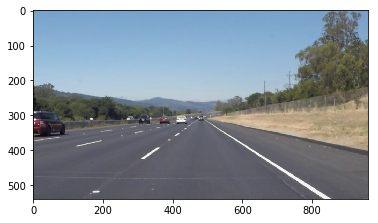

In [15]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [72]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
#     right_centre = []
#     right_slope = []
#     left_centre = []
#     left_slope = []
#     x_thresh = img.shape[1]/2
    
#     # Find the slope and centre of all the plausible points.
#     for line in lines:
#         for x1,y1,x2,y2 in line:
#             slope = (y2-y1)/(x2-x1)
#             centre = [(x1 + x2) / 2, (y1 + y2) / 2]
#             if abs(slope) > 0.55:
#                 if (x1 < x_thresh) and (x2 < x_thresh):
#                     left_centre.append(centre)
#                     left_slope.append(slope)
#                 elif (x1 > x_thresh) and (x2 > x_thresh):
#                     right_centre.append(centre)
#                     right_slope.append(slope) 
                    
#     # Calculate the average slope and centre                
#     l_slope = np.sum(left_slope) / len(left_slope)
# #     print ("Left: ", l_slope)
#     l_centre = np.divide(np.sum(left_centre, axis=0), len(left_centre))
#     r_slope = np.sum(right_slope) / len(right_slope)
# #     print ("Right: ", r_slope)
#     r_centre = np.divide(np.sum(right_centre, axis=0), len(right_centre))
    
#     # Calculate the top and bottom points to draw the line. 
#     left_bottom_y = img.shape[0]
#     left_bottom_x = int(l_centre[0] - (l_centre[1] - left_bottom_y) // l_slope)
#     left_top_y = int(img.shape[0] * 0.58)
#     left_top_x = int(l_centre[0] - (l_centre[1] - left_top_y) // l_slope)
#     cv2.line(img, (left_bottom_x, left_bottom_y), (left_top_x, left_top_y), color, thickness)
    
#     right_bottom_y = img.shape[0]
#     right_bottom_x = int(r_centre[0] - (r_centre[1] - right_bottom_y) // r_slope)
#     right_top_y = int(img.shape[0] * 0.58)
#     right_top_x = int(r_centre[0] - (r_centre[1] - right_top_y) // r_slope)
#     cv2.line(img, (right_bottom_x, right_bottom_y), (right_top_x, right_top_y), color, thickness)
            

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    plt.imshow(line_img)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [17]:
import os
os.listdir("test_images/")


['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [74]:
def pipeline(image):
    ysize, xsize = img.shape[0], img.shape[1]
    # Convert to gray scale.
    gray = grayscale(image)
    mpimg.imsave("test_images_output/"  + "gray" + test_image, gray, cmap="gray")

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 3
    blur_gray = gaussian_blur(gray, kernel_size)
    mpimg.imsave("test_images_output/" + "blur" + test_image, blur_gray, cmap="gray")

    # Define parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(gray, low_threshold, high_threshold)
    mpimg.imsave("test_images_output/" + "canny" + test_image, edges, cmap="gray")
    fig, ax = plt.subplots(figsize=(20, 10))
#     ax.imshow(edges, cmap="gray")

    # Next we'll create a masked edges image using cv2.fillPoly()
    imshape = image.shape
    vertices = np.array([[(0, imshape[0]),(0.51*imshape[1], 0.58*imshape[0]), (0.49*imshape[1], 0.58*imshape[0]), 
                          (imshape[1], imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    mpimg.imsave("test_images_output/" + "masked" + test_image, masked_edges, cmap="gray")

    # Define the Hough transform parameters
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 35 # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 3 #minimum number of pixels making up a line
    max_line_gap = 2 # maximum gap in pixels between connectable line segments
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    mpimg.imsave("test_images_output/" + "Hough_line" + test_image, lines, cmap="gray")

    # Combine line with original image
    lines_edges = weighted_img(lines, image, α=0.8, β=1., γ=0.)
#     ax.imshow(lines_edges)
    mpimg.imsave("test_images_output/" + test_image, lines_edges)
    return lines_edges

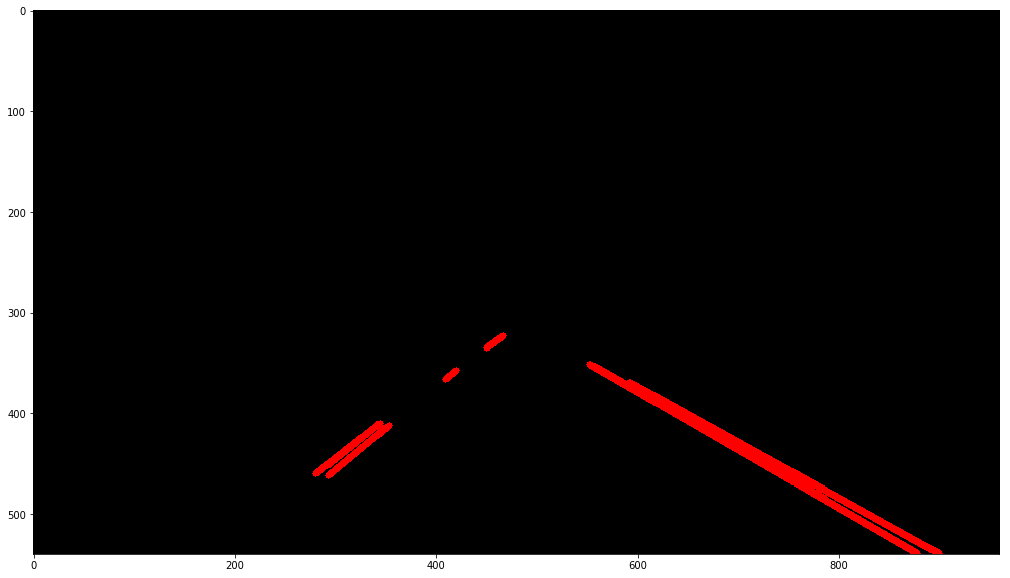

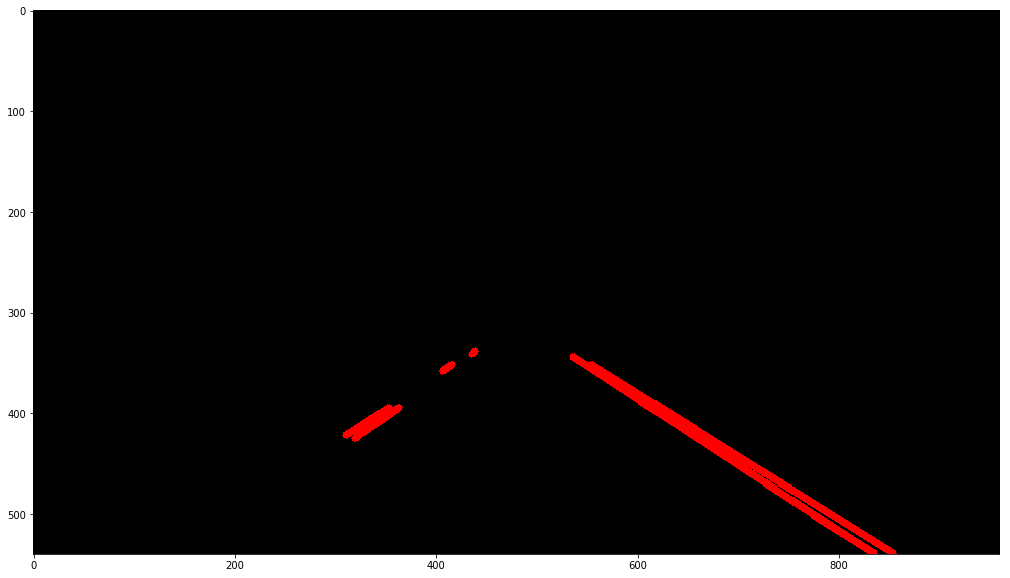

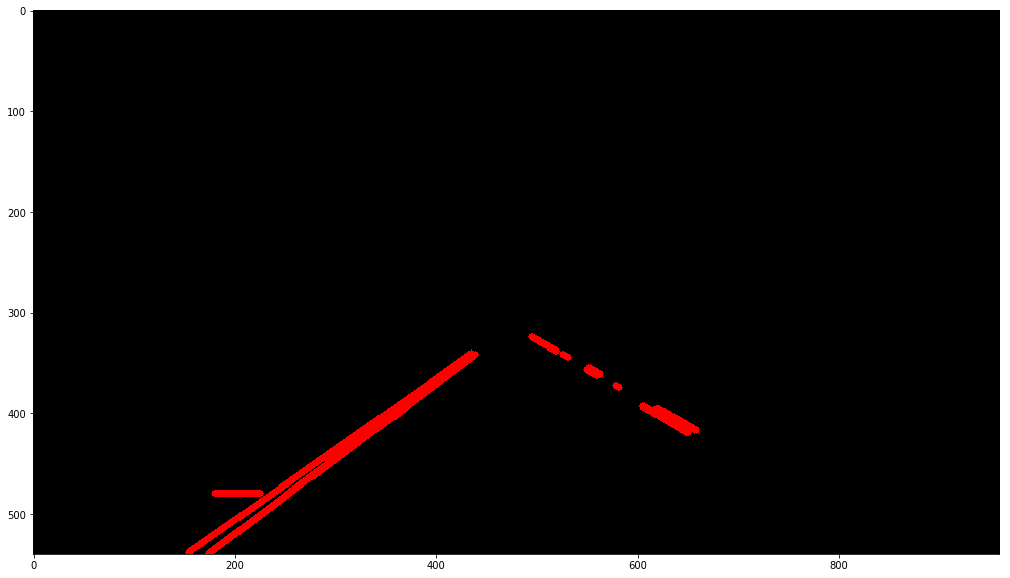

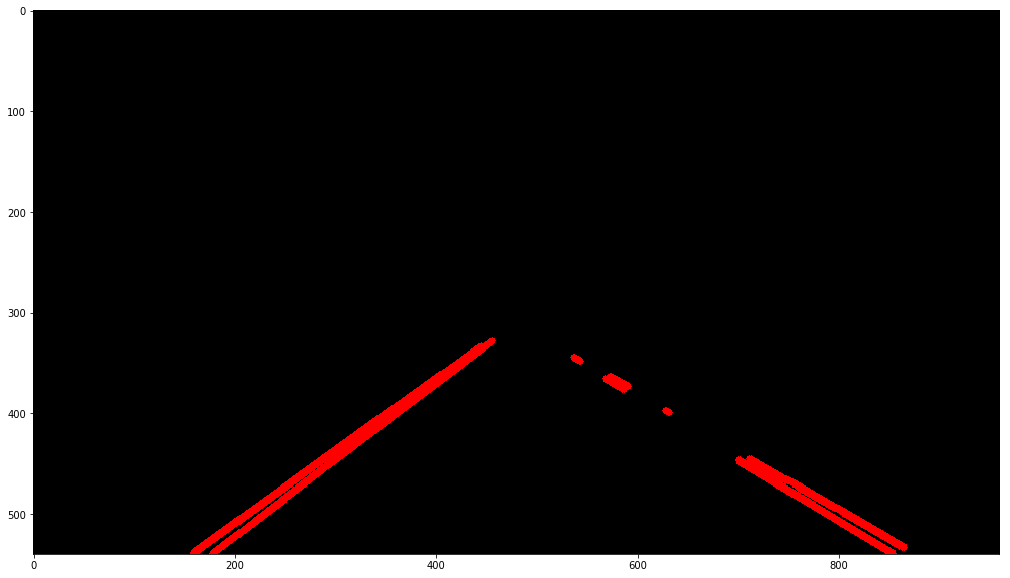

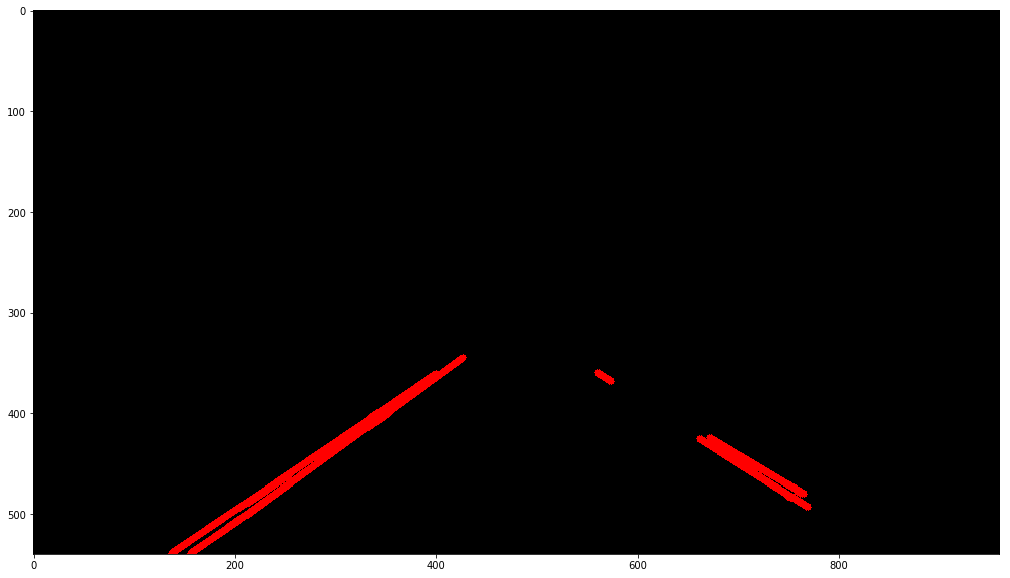

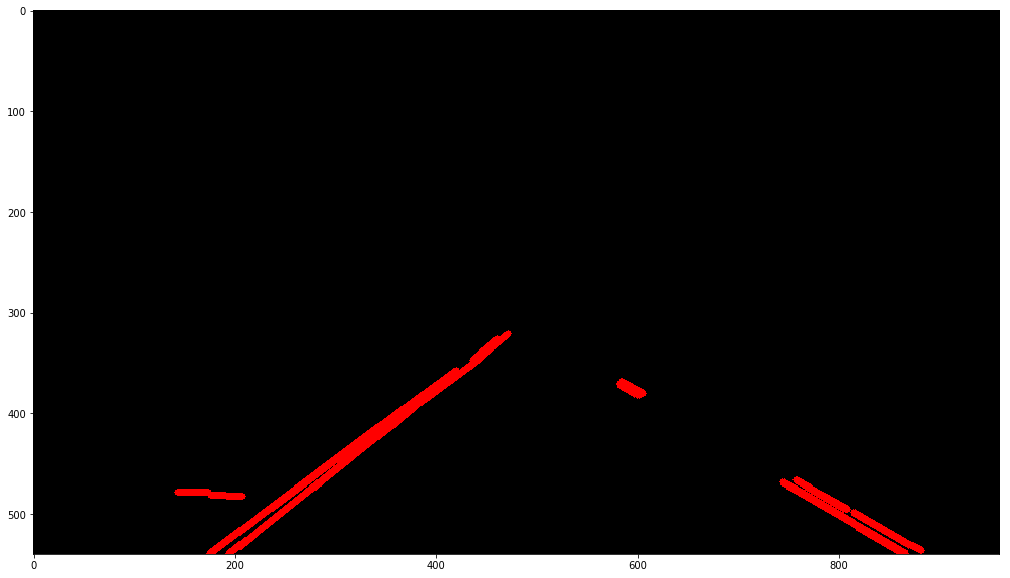

In [75]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
for test_image in os.listdir("test_images/"):
    image = mpimg.imread("test_images/" + test_image)
    lines_edges = pipeline(image)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [21]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = pipeline(image)
    plt.imshow(result)
    return result

Let's try the one with the solid white lane on the right first ...

Left:  -0.7501256167816271
Right:  0.6355388727611632
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



  0%|          | 0/126 [00:00<?, ?it/s]

Left:  -0.7501256167816271
Right:  0.6355388727611632



  1%|          | 1/126 [00:01<02:41,  1.29s/it]

Left:  -0.7215176096685393
Right:  0.624854535881796



  2%|▏         | 2/126 [00:02<02:43,  1.32s/it]

Left:  -0.7028764045722675
Right:  0.6204499358647552



  2%|▏         | 3/126 [00:03<02:41,  1.32s/it]

Left:  -0.7197723046619481
Right:  0.6172884497142429



  3%|▎         | 4/126 [00:05<02:39,  1.31s/it]

Left:  -0.6891025641025642
Right:  0.6049900793155419



  4%|▍         | 5/126 [00:06<02:38,  1.31s/it]

Left:  -0.7337092731829574
Right:  0.6149638144339535



  5%|▍         | 6/126 [00:07<02:34,  1.29s/it]

Left:  -0.7218146496135113
Right:  0.6195628367206985



  6%|▌         | 7/126 [00:09<02:30,  1.27s/it]

Left:  -0.704387236206458
Right:  0.6088364169557712



  6%|▋         | 8/126 [00:10<02:27,  1.25s/it]

Left:  -0.7063916887922438
Right:  0.6152437069688139



  7%|▋         | 9/126 [00:11<02:26,  1.25s/it]

Left:  -0.7328508771929825
Right:  0.6175695967101054



  8%|▊         | 10/126 [00:12<02:22,  1.23s/it]

Left:  -0.7072521894133147
Right:  0.613251708414708



  9%|▊         | 11/126 [00:13<02:21,  1.23s/it]

Left:  -0.7115014645187059
Right:  0.6312221187883209



 10%|▉         | 12/126 [00:15<02:18,  1.21s/it]

Left:  -0.7083837373789844
Right:  0.6338756625356766



 10%|█         | 13/126 [00:16<02:15,  1.19s/it]

Left:  -0.722680983125062
Right:  0.638570508835014



 11%|█         | 14/126 [00:17<02:15,  1.21s/it]

Left:  -0.7111042794813391
Right:  0.6395711229089619



 12%|█▏        | 15/126 [00:18<02:11,  1.19s/it]

Left:  -0.7224294624294625
Right:  0.6462014355677178



 13%|█▎        | 16/126 [00:19<02:09,  1.18s/it]

Left:  -0.7008109040717736
Right:  0.647285351866168



 13%|█▎        | 17/126 [00:20<02:08,  1.18s/it]

Left:  -0.6604938271604938
Right:  0.6530633437224526



 14%|█▍        | 18/126 [00:22<02:06,  1.18s/it]

Left:  -0.6875076804915514
Right:  0.6665582051669847



 15%|█▌        | 19/126 [00:23<02:05,  1.18s/it]

Left:  -0.7197724039829303
Right:  0.6400746550256962



 16%|█▌        | 20/126 [00:24<02:06,  1.19s/it]

Left:  -0.7011114668539481
Right:  0.645301678124996



 17%|█▋        | 21/126 [00:25<02:04,  1.19s/it]

Left:  -0.688215957403944
Right:  0.6401139804029616



 17%|█▋        | 22/126 [00:27<02:07,  1.23s/it]

Left:  -0.6912857714710519
Right:  0.6405259258452791



 18%|█▊        | 23/126 [00:28<02:08,  1.24s/it]

Left:  -0.7015916557614222
Right:  0.6405583415829781



 19%|█▉        | 24/126 [00:29<02:07,  1.25s/it]

Left:  -0.6913000975326692
Right:  0.6344591651294369



 20%|█▉        | 25/126 [00:30<02:08,  1.27s/it]

Left:  -0.6803885549689493
Right:  0.641767734898828



 21%|██        | 26/126 [00:32<02:09,  1.29s/it]

Left:  -0.6990404515075567
Right:  0.6420389299536295



 21%|██▏       | 27/126 [00:33<02:08,  1.30s/it]

Left:  -0.7018814849171993
Right:  0.6379447437028926



 22%|██▏       | 28/126 [00:34<02:08,  1.31s/it]

Left:  -0.7023809523809524
Right:  0.6347178406089191



 23%|██▎       | 29/126 [00:36<02:06,  1.31s/it]

Left:  -0.6979146141215106
Right:  0.6358206397030368



 24%|██▍       | 30/126 [00:37<02:03,  1.28s/it]

Left:  -0.7120328282828282
Right:  0.6357640005239406



 25%|██▍       | 31/126 [00:38<02:02,  1.29s/it]

Left:  -0.7027527527527527
Right:  0.6358605209286029



 25%|██▌       | 32/126 [00:39<02:00,  1.28s/it]

Left:  -0.7022366522366522
Right:  0.6334021492240333



 26%|██▌       | 33/126 [00:41<01:56,  1.26s/it]

Left:  -0.7046950598421187
Right:  0.6390671734808269



 27%|██▋       | 34/126 [00:42<01:54,  1.24s/it]

Left:  -0.6966042442100909
Right:  0.6335440887181145



 28%|██▊       | 35/126 [00:43<01:52,  1.23s/it]

Left:  -0.7185549316071406
Right:  0.6380632845484756



 29%|██▊       | 36/126 [00:44<01:52,  1.25s/it]

Left:  -0.7119713849010344
Right:  0.6381763351295698



 29%|██▉       | 37/126 [00:46<01:53,  1.27s/it]

Left:  -0.6983719983719984
Right:  0.651047261769988



 30%|███       | 38/126 [00:47<01:51,  1.27s/it]

Left:  -0.7369395744256456
Right:  0.6438503326745603



 31%|███       | 39/126 [00:48<01:48,  1.25s/it]

Left:  -0.6898831133905761
Right:  0.6449972968813086



 32%|███▏      | 40/126 [00:49<01:45,  1.23s/it]

Left:  -0.7008441558441558
Right:  0.6550286874837651



 33%|███▎      | 41/126 [00:51<01:43,  1.22s/it]

Left:  -0.7318518518518519
Right:  0.6535555696227783



 33%|███▎      | 42/126 [00:52<01:43,  1.23s/it]

Left:  -0.7230603448275862
Right:  0.6553772390775886



 34%|███▍      | 43/126 [00:53<01:41,  1.23s/it]

Left:  -0.7303571428571429
Right:  0.6501271718020488



 35%|███▍      | 44/126 [00:54<01:40,  1.22s/it]

Left:  -0.7199855699855701
Right:  0.6463994219674839



 36%|███▌      | 45/126 [00:56<01:41,  1.25s/it]

Left:  -0.7418967587034814
Right:  0.6510742565735539



 37%|███▋      | 46/126 [00:57<01:41,  1.27s/it]

Left:  -0.7234848484848485
Right:  0.6435790881898531



 37%|███▋      | 47/126 [00:58<01:38,  1.25s/it]

Left:  -0.7302987408932531
Right:  0.6452542235832627



 38%|███▊      | 48/126 [00:59<01:36,  1.24s/it]

Left:  -0.7220737491362722
Right:  0.6398259464530173



 39%|███▉      | 49/126 [01:01<01:34,  1.23s/it]

Left:  -0.7202291228118837
Right:  0.6494263980523275



 40%|███▉      | 50/126 [01:02<01:32,  1.22s/it]

Left:  -0.7029824561403508
Right:  0.6455465350259362



 40%|████      | 51/126 [01:03<01:31,  1.21s/it]

Left:  -0.7101825404872607
Right:  0.6374468379049477



 41%|████▏     | 52/126 [01:04<01:28,  1.20s/it]

Left:  -0.6906640917236461
Right:  0.6453458628173714



 42%|████▏     | 53/126 [01:05<01:31,  1.25s/it]

Left:  -0.6920024420024421
Right:  0.638957024957675



 43%|████▎     | 54/126 [01:07<01:30,  1.26s/it]

Left:  -0.7005952380952382
Right:  0.6480712979046506



 44%|████▎     | 55/126 [01:08<01:28,  1.25s/it]

Left:  -0.6990900383141762
Right:  0.6402812365675908



 44%|████▍     | 56/126 [01:09<01:27,  1.25s/it]

Left:  -0.6944751466028062
Right:  0.6488331636449793



 45%|████▌     | 57/126 [01:10<01:24,  1.23s/it]

Left:  -0.6973886328725037
Right:  0.6499530086871538



 46%|████▌     | 58/126 [01:12<01:24,  1.24s/it]

Left:  -0.6796695951107715
Right:  0.6434552212844303



 47%|████▋     | 59/126 [01:13<01:22,  1.23s/it]

Left:  -0.7016737133535882
Right:  0.6481684762191646



 48%|████▊     | 60/126 [01:14<01:21,  1.23s/it]

Left:  -0.6832060163188785
Right:  0.659471996874209



 48%|████▊     | 61/126 [01:15<01:21,  1.25s/it]

Left:  -0.6959820017544276
Right:  0.655890693914646



 49%|████▉     | 62/126 [01:17<01:19,  1.24s/it]

Left:  -0.6753406447324692
Right:  0.6513728902543362



 50%|█████     | 63/126 [01:18<01:17,  1.22s/it]

Left:  -0.6646885521885522
Right:  0.6569569877042013



 51%|█████     | 64/126 [01:19<01:20,  1.29s/it]

Left:  -0.6703528958963743
Right:  0.6585310094167901



 52%|█████▏    | 65/126 [01:20<01:17,  1.27s/it]

Left:  -0.6865028490028491
Right:  0.6438064386143886



 52%|█████▏    | 66/126 [01:22<01:15,  1.25s/it]

Left:  -0.6555555555555556
Right:  0.6397602358967206



 53%|█████▎    | 67/126 [01:23<01:13,  1.24s/it]

Left:  -0.6941280566280567
Right:  0.6421525975831271



 54%|█████▍    | 68/126 [01:24<01:10,  1.21s/it]

Left:  -0.6608225108225108
Right:  0.6572040324106624



 55%|█████▍    | 69/126 [01:25<01:08,  1.21s/it]

Left:  -0.6781111304920828
Right:  0.65410720997989



 56%|█████▌    | 70/126 [01:26<01:07,  1.21s/it]

Left:  -0.6712287302458166
Right:  0.6574828112681242



 56%|█████▋    | 71/126 [01:28<01:11,  1.30s/it]

Left:  -0.6801495598239296
Right:  0.6567225947849776



 57%|█████▋    | 72/126 [01:29<01:11,  1.32s/it]

Left:  -0.6899410446428795
Right:  0.6685226868624553



 58%|█████▊    | 73/126 [01:31<01:08,  1.30s/it]

Left:  -0.6737531930611654
Right:  0.6602115670647252



 59%|█████▊    | 74/126 [01:32<01:15,  1.45s/it]

Left:  -0.6715941943867326
Right:  0.6493739797570893



 60%|█████▉    | 75/126 [01:34<01:18,  1.55s/it]

Left:  -0.6520986118386589
Right:  0.6573563186267983



 60%|██████    | 76/126 [01:36<01:20,  1.62s/it]

Left:  -0.6440408432147562
Right:  0.6621859553103313



 61%|██████    | 77/126 [01:37<01:17,  1.59s/it]

Left:  -0.6496305418719213
Right:  0.6659693551080682



 62%|██████▏   | 78/126 [01:39<01:15,  1.57s/it]

Left:  -0.6250744047619048
Right:  0.6805607559098066



 63%|██████▎   | 79/126 [01:41<01:17,  1.65s/it]

Left:  -0.6495726495726496
Right:  0.673266004197885



 63%|██████▎   | 80/126 [01:42<01:16,  1.66s/it]

Left:  -0.6600580270793037
Right:  0.6820748761074303



 64%|██████▍   | 81/126 [01:44<01:13,  1.64s/it]

Left:  -0.6617010440539852
Right:  0.6783836496196662



 65%|██████▌   | 82/126 [01:46<01:09,  1.59s/it]

Left:  -0.6570594828057514
Right:  0.6724639765680456



 66%|██████▌   | 83/126 [01:47<01:05,  1.53s/it]

Left:  -0.6444014429812273
Right:  0.6735595374618324



 67%|██████▋   | 84/126 [01:48<01:03,  1.51s/it]

Left:  -0.6614815852719078
Right:  0.671497909076939



 67%|██████▋   | 85/126 [01:50<01:03,  1.54s/it]

Left:  -0.6535478410087372
Right:  0.6686592791685055



 68%|██████▊   | 86/126 [01:51<00:59,  1.49s/it]

Left:  -0.6567220888355342
Right:  0.6733958679980787



 69%|██████▉   | 87/126 [01:53<00:56,  1.46s/it]

Left:  -0.679632491002973
Right:  0.6687093272645778



 70%|██████▉   | 88/126 [01:54<00:56,  1.49s/it]

Left:  -0.6533640765838907
Right:  0.6725029977586826



 71%|███████   | 89/126 [01:56<00:54,  1.48s/it]

Left:  -0.6444444444444444
Right:  0.6876055561364719



 71%|███████▏  | 90/126 [01:57<00:53,  1.47s/it]

Left:  -0.6514864010120177
Right:  0.6887750816390248



 72%|███████▏  | 91/126 [01:59<00:51,  1.47s/it]

Left:  -0.6405372764068415
Right:  0.6885242461287147



 73%|███████▎  | 92/126 [02:00<00:51,  1.51s/it]

Left:  -0.6536220871327254
Right:  0.6886866613395842



 74%|███████▍  | 93/126 [02:02<00:48,  1.48s/it]

Left:  -0.6302059052059054
Right:  0.685097967723599



 75%|███████▍  | 94/126 [02:03<00:46,  1.46s/it]

Left:  -0.6536796536796537
Right:  0.6928586537611074



 75%|███████▌  | 95/126 [02:05<00:44,  1.45s/it]

Left:  -0.6402324065187953
Right:  0.6832108650373994



 76%|███████▌  | 96/126 [02:06<00:43,  1.44s/it]

Left:  -0.6621016490673879
Right:  0.6852112655657627



 77%|███████▋  | 97/126 [02:07<00:41,  1.43s/it]

Left:  -0.6606259511680307
Right:  0.6992071010844159



 78%|███████▊  | 98/126 [02:09<00:40,  1.45s/it]

Left:  -0.6580990113026198
Right:  0.6985386216781909



 79%|███████▊  | 99/126 [02:10<00:39,  1.47s/it]

Left:  -0.6437651892620836
Right:  0.6988178898872142



 79%|███████▉  | 100/126 [02:12<00:38,  1.47s/it]

Left:  -0.6590962367049323
Right:  0.6964807058384532



 80%|████████  | 101/126 [02:13<00:36,  1.48s/it]

Left:  -0.6628205128205128
Right:  0.7092827106181561



 81%|████████  | 102/126 [02:15<00:38,  1.59s/it]

Left:  -0.6520833333333333
Right:  0.6915130810411425



 82%|████████▏ | 103/126 [02:17<00:36,  1.59s/it]

Left:  -0.7020165789893194
Right:  0.6922754861885296



 83%|████████▎ | 104/126 [02:18<00:33,  1.52s/it]

Left:  -0.6724420677361853
Right:  0.6907993571593596



 83%|████████▎ | 105/126 [02:20<00:31,  1.52s/it]

Left:  -0.7056382357706223
Right:  0.689813492873727



 84%|████████▍ | 106/126 [02:21<00:30,  1.50s/it]

Left:  -0.6654202468851499
Right:  0.6825979105640123



 85%|████████▍ | 107/126 [02:23<00:28,  1.48s/it]

Left:  -0.660128205128205
Right:  0.6832676113676358



 86%|████████▌ | 108/126 [02:24<00:26,  1.48s/it]

Left:  -0.6926741826913135
Right:  0.6934857002683992



 87%|████████▋ | 109/126 [02:25<00:24,  1.47s/it]

Left:  -0.6848583062362261
Right:  0.6823497330428023



 87%|████████▋ | 110/126 [02:27<00:23,  1.45s/it]

Left:  -0.6669815666139195
Right:  0.6862383662715521



 88%|████████▊ | 111/126 [02:28<00:21,  1.43s/it]

Left:  -0.6944435645655158
Right:  0.682879198907337



 89%|████████▉ | 112/126 [02:30<00:20,  1.45s/it]

Left:  -0.6715079657184919
Right:  0.682085993047823



 90%|████████▉ | 113/126 [02:31<00:19,  1.48s/it]

Left:  -0.678943781314471
Right:  0.6811143008971471



 90%|█████████ | 114/126 [02:33<00:17,  1.48s/it]

Left:  -0.6791386033321517
Right:  0.6813008546507472



 91%|█████████▏| 115/126 [02:34<00:15,  1.43s/it]

Left:  -0.6873301265586326
Right:  0.6691938448124475



 92%|█████████▏| 116/126 [02:35<00:13,  1.36s/it]

Left:  -0.6690954011266511
Right:  0.6795797867542811



 93%|█████████▎| 117/126 [02:36<00:11,  1.30s/it]

Left:  -0.6755769230769231
Right:  0.6688636658781673



 94%|█████████▎| 118/126 [02:38<00:09,  1.24s/it]

Left:  -0.679554208828634
Right:  0.6648423348243676



 94%|█████████▍| 119/126 [02:39<00:08,  1.24s/it]

Left:  -0.6908476919516664
Right:  0.6588297102933254



 95%|█████████▌| 120/126 [02:40<00:07,  1.22s/it]

Left:  -0.6822532705956543
Right:  0.645278368533132



 96%|█████████▌| 121/126 [02:41<00:06,  1.26s/it]

Left:  -0.6797277808708728
Right:  0.6472864001032793



 97%|█████████▋| 122/126 [02:43<00:04,  1.24s/it]

Left:  -0.678264445313009
Right:  0.6563289443341832



 98%|█████████▊| 123/126 [02:44<00:03,  1.21s/it]

Left:  -0.6721077024795754
Right:  0.6535030498419873



 98%|█████████▊| 124/126 [02:45<00:02,  1.20s/it]

Left:  -0.6866810663163248
Right:  0.6470186215038263



 99%|█████████▉| 125/126 [02:46<00:01,  1.19s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2min 25s, sys: 4.48 s, total: 2min 30s
Wall time: 2min 47s


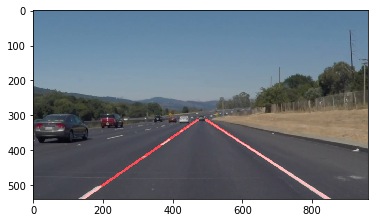

In [50]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [43]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

Left:  -0.6205939873321863
Right:  0.651010101010101
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



  0%|          | 0/682 [00:00<?, ?it/s]

Left:  -0.6205939873321863
Right:  0.651010101010101



  0%|          | 1/682 [00:01<13:08,  1.16s/it]

Left:  -0.6088175709695637
Right:  0.6759952717901032



  0%|          | 2/682 [00:02<13:29,  1.19s/it]

Left:  -0.6418183480534659
Right:  0.6694841042766436



  0%|          | 3/682 [00:03<13:42,  1.21s/it]

Left:  -0.6314231654730768
Right:  0.6797599684392794



  1%|          | 4/682 [00:04<13:20,  1.18s/it]

Left:  -0.6288248621369548
Right:  0.6824827614682687



  1%|          | 5/682 [00:05<13:13,  1.17s/it]

Left:  -0.664358305707983
Right:  0.6705555555555556



  1%|          | 6/682 [00:07<13:03,  1.16s/it]

Left:  -0.6386904282873151
Right:  0.6585497835497836



  1%|          | 7/682 [00:08<12:48,  1.14s/it]

Left:  -0.6562704613864524
Right:  0.6594135197076374



  1%|          | 8/682 [00:09<12:35,  1.12s/it]

Left:  -0.6505752609691107
Right:  0.6840550989877796



  1%|▏         | 9/682 [00:10<12:43,  1.13s/it]

Left:  -0.6518051786927874
Right:  0.6316970031255745



  1%|▏         | 10/682 [00:11<12:35,  1.12s/it]

Left:  -0.6522213941324334
Right:  0.6481178396072014



  2%|▏         | 11/682 [00:12<12:36,  1.13s/it]

Left:  -0.6595260337763393
Right:  0.6567549437088024



  2%|▏         | 12/682 [00:13<12:34,  1.13s/it]

Left:  -0.6810374996776856
Right:  0.64280480560703



  2%|▏         | 13/682 [00:14<12:33,  1.13s/it]

Left:  -0.6685009699944937
Right:  0.6330953872481521



  2%|▏         | 14/682 [00:16<12:29,  1.12s/it]

Left:  -0.6907665648168413
Right:  0.645582741759779



  2%|▏         | 15/682 [00:17<12:36,  1.13s/it]

Left:  -0.6837701456119358
Right:  0.6479550154174561



  2%|▏         | 16/682 [00:18<12:39,  1.14s/it]

Left:  -0.6922335696190944
Right:  0.6403486862391874



  2%|▏         | 17/682 [00:19<12:42,  1.15s/it]

Left:  -0.6962501272022238
Right:  0.6498412698412698



  3%|▎         | 18/682 [00:20<12:57,  1.17s/it]

Left:  -0.6964322852542889
Right:  0.6297101449275362



  3%|▎         | 19/682 [00:21<12:57,  1.17s/it]

Left:  -0.6912137275990465
Right:  0.6577380952380952



  3%|▎         | 20/682 [00:23<12:48,  1.16s/it]

Left:  -0.6852334689278711
Right:  0.611244019138756



  3%|▎         | 21/682 [00:24<12:41,  1.15s/it]

Left:  -0.6939244593015457
Right:  0.6124528301886792



  3%|▎         | 22/682 [00:25<12:39,  1.15s/it]

Left:  -0.6867880065846044
Right:  0.6226016047444619



  3%|▎         | 23/682 [00:26<12:35,  1.15s/it]

Left:  -0.6935211549348496
Right:  0.6311175666438824



  4%|▎         | 24/682 [00:27<12:50,  1.17s/it]

Left:  -0.6996929644311801
Right:  0.6345174604103175



  4%|▎         | 25/682 [00:28<12:40,  1.16s/it]

Left:  -0.70515627319048
Right:  0.6274983095739551



  4%|▍         | 26/682 [00:30<12:54,  1.18s/it]

Left:  -0.7036411485549461
Right:  0.6269703741137964



  4%|▍         | 27/682 [00:31<12:42,  1.16s/it]

Left:  -0.6945544643199751
Right:  0.6164419663786752



  4%|▍         | 28/682 [00:32<12:37,  1.16s/it]

Left:  -0.719002766783336
Right:  0.6029481902444654



  4%|▍         | 29/682 [00:33<13:21,  1.23s/it]

Left:  -0.721541867813181
Right:  0.6120824305455246



  4%|▍         | 30/682 [00:34<12:59,  1.20s/it]

Left:  -0.7225395442016546
Right:  0.6



  5%|▍         | 31/682 [00:36<13:09,  1.21s/it]

Left:  -0.7219509765839397
Right:  0.5903225806451613



  5%|▍         | 32/682 [00:37<12:57,  1.20s/it]

Left:  -0.7180651769512001
Right:  0.5982384823848239



  5%|▍         | 33/682 [00:38<12:46,  1.18s/it]

Left:  -0.7262184311376232
Right:  0.5933747412008281



  5%|▍         | 34/682 [00:39<12:33,  1.16s/it]

Left:  -0.7301142831991784
Right:  0.6069438378292188



  5%|▌         | 35/682 [00:40<12:30,  1.16s/it]

Left:  -0.7383144063360843
Right:  0.6257631257631258



  5%|▌         | 36/682 [00:41<12:51,  1.19s/it]

Left:  -0.734000104427736
Right:  0.6311890838206627



  5%|▌         | 37/682 [00:43<12:47,  1.19s/it]

Left:  -0.7406225466654353
Right:  0.603130749073823



  6%|▌         | 38/682 [00:44<12:47,  1.19s/it]

Left:  -0.7378806927247917
Right:  0.5988744263180223



  6%|▌         | 39/682 [00:45<12:42,  1.19s/it]

Left:  -0.7290609712536598
Right:  0.594986699478132



  6%|▌         | 40/682 [00:46<12:54,  1.21s/it]

Left:  -0.7150874480536066
Right:  0.5950490806402137



  6%|▌         | 41/682 [00:47<12:49,  1.20s/it]

Left:  -0.7377195539612869
Right:  0.6042919925967529



  6%|▌         | 42/682 [00:49<12:50,  1.20s/it]

Left:  -0.7309344629191976
Right:  0.5813492063492063



  6%|▋         | 43/682 [00:50<12:50,  1.21s/it]

Left:  -0.7386717851308464
Right:  0.6060606060606061



  6%|▋         | 44/682 [00:51<12:34,  1.18s/it]

Left:  -0.7370852114067242
Right:  0.6238425925925926



  7%|▋         | 45/682 [00:52<12:28,  1.18s/it]

Left:  -0.7370901881653283
Right:  0.6257515632515632



  7%|▋         | 46/682 [00:53<12:37,  1.19s/it]

Left:  -0.7459121992790453
Right:  0.6159307359307359



  7%|▋         | 47/682 [00:55<13:01,  1.23s/it]

Left:  -0.7417967033474597
Right:  0.6036706349206349



  7%|▋         | 48/682 [00:56<12:53,  1.22s/it]

Left:  -0.7363171532421213
Right:  0.6096870612495613



  7%|▋         | 49/682 [00:57<12:52,  1.22s/it]

Left:  -0.7496267412688983
Right:  0.5944471873868536



  7%|▋         | 50/682 [00:58<12:50,  1.22s/it]

Left:  -0.7420395517296924
Right:  0.6070129075872079



  7%|▋         | 51/682 [00:59<12:39,  1.20s/it]

Left:  -0.7312063295729188
Right:  0.6171046958843798



  8%|▊         | 52/682 [01:01<12:25,  1.18s/it]

Left:  -0.7214965516397118
Right:  0.603484332154018



  8%|▊         | 53/682 [01:02<12:13,  1.17s/it]

Left:  -0.7231368460334021
Right:  0.6028894864001247



  8%|▊         | 54/682 [01:03<12:04,  1.15s/it]

Left:  -0.7238592709901673
Right:  0.6212255444813584



  8%|▊         | 55/682 [01:04<11:56,  1.14s/it]

Left:  -0.7261627188874843
Right:  0.593103448275862



  8%|▊         | 56/682 [01:05<11:50,  1.14s/it]

Left:  -0.7342452778148983
Right:  0.6558799202062959



  8%|▊         | 57/682 [01:06<11:50,  1.14s/it]

Left:  -0.7311342592592592
Right:  0.6453899911472596



  9%|▊         | 58/682 [01:07<11:51,  1.14s/it]

Left:  -0.7302813767647526
Right:  0.589262187088274



  9%|▊         | 59/682 [01:09<11:56,  1.15s/it]

Left:  -0.712113939832633
Right:  0.6558347425994485



  9%|▉         | 60/682 [01:10<11:51,  1.14s/it]

Left:  -0.7094896691135084
Right:  0.6283394383394383



  9%|▉         | 61/682 [01:11<11:53,  1.15s/it]

Left:  -0.7164716391433206
Right:  0.5975668111231492



  9%|▉         | 62/682 [01:12<11:49,  1.14s/it]

Left:  -0.7074759144536996
Right:  0.5969504270746506



  9%|▉         | 63/682 [01:13<11:49,  1.15s/it]

Left:  -0.7041404870087695
Right:  0.6077863127829088



  9%|▉         | 64/682 [01:14<11:38,  1.13s/it]

Left:  -0.6988380672528691
Right:  0.6027120269004204



 10%|▉         | 65/682 [01:15<11:37,  1.13s/it]

Left:  -0.6973195422769033
Right:  0.614754834569732



 10%|▉         | 66/682 [01:16<11:32,  1.12s/it]

Left:  -0.6967486419252908
Right:  0.6455043595243233



 10%|▉         | 67/682 [01:18<11:30,  1.12s/it]

Left:  -0.6974871326965868
Right:  0.6645825602968459



 10%|▉         | 68/682 [01:19<11:26,  1.12s/it]

Left:  -0.6952737941493753
Right:  0.642576476233036



 10%|█         | 69/682 [01:20<11:25,  1.12s/it]

Left:  -0.7006030917862635
Right:  0.6395521261919944



 10%|█         | 70/682 [01:21<11:24,  1.12s/it]

Left:  -0.7026694348394407
Right:  0.627092352092352



 10%|█         | 71/682 [01:22<11:28,  1.13s/it]

Left:  -0.7034058939168428
Right:  0.5969721767594107



 11%|█         | 72/682 [01:23<11:31,  1.13s/it]

Left:  -0.6989849608114758
Right:  0.6079647849996688



 11%|█         | 73/682 [01:24<11:26,  1.13s/it]

Left:  -0.7135925459619998
Right:  0.6265822423775705



 11%|█         | 74/682 [01:25<11:20,  1.12s/it]

Left:  -0.7170165589760402
Right:  0.6213586279582255



 11%|█         | 75/682 [01:27<11:15,  1.11s/it]

Left:  -0.7010802323463227
Right:  0.6105861910125476



 11%|█         | 76/682 [01:28<11:15,  1.12s/it]

Left:  -0.7165286169133368
Right:  0.6245926324057179



 11%|█▏        | 77/682 [01:29<11:14,  1.11s/it]

Left:  -0.7018401995694304
Right:  0.6095429490483971



 11%|█▏        | 78/682 [01:30<11:17,  1.12s/it]

Left:  -0.7044425840364282
Right:  0.6286114529195261



 12%|█▏        | 79/682 [01:31<11:16,  1.12s/it]

Left:  -0.6920448235068652
Right:  0.634350535503059



 12%|█▏        | 80/682 [01:32<11:13,  1.12s/it]

Left:  -0.7085729738233744
Right:  0.6385281385281386



 12%|█▏        | 81/682 [01:33<11:14,  1.12s/it]

Left:  -0.697839300396103
Right:  0.6476190476190475



 12%|█▏        | 82/682 [01:34<11:11,  1.12s/it]

Left:  -0.6997291418451569
Right:  0.6611226611226612



 12%|█▏        | 83/682 [01:35<11:04,  1.11s/it]

Left:  -0.7047370060215653
Right:  0.6276541961577351



 12%|█▏        | 84/682 [01:37<11:06,  1.11s/it]

Left:  -0.7045538707356735
Right:  0.6348655572533802



 12%|█▏        | 85/682 [01:38<11:07,  1.12s/it]

Left:  -0.7029933083460718
Right:  0.6492471988795517



 13%|█▎        | 86/682 [01:39<11:05,  1.12s/it]

Left:  -0.6938725539023307
Right:  0.6422038461018971



 13%|█▎        | 87/682 [01:40<11:02,  1.11s/it]

Left:  -0.6905291222089918
Right:  0.6304728516164686



 13%|█▎        | 88/682 [01:41<11:03,  1.12s/it]

Left:  -0.685850263780332
Right:  0.6350981497451413



 13%|█▎        | 89/682 [01:42<11:04,  1.12s/it]

Left:  -0.6895034435508658
Right:  0.6354467886518981



 13%|█▎        | 90/682 [01:43<11:02,  1.12s/it]

Left:  -0.6838077844956777
Right:  0.6390355940110265



 13%|█▎        | 91/682 [01:44<11:05,  1.13s/it]

Left:  -0.6810284100972169
Right:  0.6441390877097443



 13%|█▎        | 92/682 [01:46<10:55,  1.11s/it]

Left:  -0.6843889121566072
Right:  0.6385281385281385



 14%|█▎        | 93/682 [01:47<10:50,  1.10s/it]

Left:  -0.7086551145890906
Right:  0.6600487634970393



 14%|█▍        | 94/682 [01:48<10:43,  1.09s/it]

Left:  -0.7305381957254179
Right:  0.625938502169402



 14%|█▍        | 95/682 [01:49<10:41,  1.09s/it]

Left:  -0.6940088729105938
Right:  0.6347687400318979



 14%|█▍        | 96/682 [01:50<10:39,  1.09s/it]

Left:  -0.6899007461388339
Right:  0.6252532201964608



 14%|█▍        | 97/682 [01:51<10:34,  1.08s/it]

Left:  -0.7085654183735929
Right:  0.6400691699604742



 14%|█▍        | 98/682 [01:52<10:33,  1.08s/it]

Left:  -0.6913707347686221
Right:  0.6406926406926406



 15%|█▍        | 99/682 [01:53<10:35,  1.09s/it]

Left:  -0.7134777409431312
Right:  0.6459011164274322



 15%|█▍        | 100/682 [01:54<10:34,  1.09s/it]

Left:  -0.6925133182718796
Right:  0.643289648622982



 15%|█▍        | 101/682 [01:55<10:34,  1.09s/it]

Left:  -0.6881882973781929
Right:  0.6268861097228936



 15%|█▍        | 102/682 [01:56<10:47,  1.12s/it]

Left:  -0.6903136164313147
Right:  0.637338212706031



 15%|█▌        | 103/682 [01:58<10:50,  1.12s/it]

Left:  -0.7041307093789819
Right:  0.6195235692838985



 15%|█▌        | 104/682 [01:59<10:47,  1.12s/it]

Left:  -0.6939045343967666
Right:  0.6068513232442421



 15%|█▌        | 105/682 [02:00<10:47,  1.12s/it]

Left:  -0.7189671917611089
Right:  0.6402771335807049



 16%|█▌        | 106/682 [02:01<10:51,  1.13s/it]

Left:  -0.6919621828442262
Right:  0.625



 16%|█▌        | 107/682 [02:02<10:48,  1.13s/it]

Left:  -0.69943639212955
Right:  0.6431583386042589



 16%|█▌        | 108/682 [02:03<10:46,  1.13s/it]

Left:  -0.6972862495042144
Right:  0.6194444444444445



 16%|█▌        | 109/682 [02:04<10:44,  1.13s/it]

Left:  -0.6788374150427402
Right:  0.6380973193473194



 16%|█▌        | 110/682 [02:05<10:44,  1.13s/it]

Left:  -0.6907803968265879
Right:  0.6419166666666667



 16%|█▋        | 111/682 [02:07<10:46,  1.13s/it]

Left:  -0.6901853593561305
Right:  0.6376884920634921



 16%|█▋        | 112/682 [02:08<10:45,  1.13s/it]

Left:  -0.693420637972534
Right:  0.6150705621710061



 17%|█▋        | 113/682 [02:09<10:41,  1.13s/it]

Left:  -0.6904953980916553
Right:  0.6415039753275047



 17%|█▋        | 114/682 [02:10<10:40,  1.13s/it]

Left:  -0.6855040401078346
Right:  0.6060287563258702



 17%|█▋        | 115/682 [02:11<10:43,  1.14s/it]

Left:  -0.6981743233237239
Right:  0.6264900061613425



 17%|█▋        | 116/682 [02:12<10:38,  1.13s/it]

Left:  -0.6962573168826368
Right:  0.6186716974522896



 17%|█▋        | 117/682 [02:13<10:40,  1.13s/it]

Left:  -0.6992878416507537
Right:  0.6271379634857895



 17%|█▋        | 118/682 [02:15<10:35,  1.13s/it]

Left:  -0.6922052342269002
Right:  0.6315536315536315



 17%|█▋        | 119/682 [02:16<10:27,  1.11s/it]

Left:  -0.7166047492226327
Right:  0.6045454545454545



 18%|█▊        | 120/682 [02:17<10:23,  1.11s/it]

Left:  -0.6932733222561739
Right:  0.64613880742913



 18%|█▊        | 121/682 [02:18<10:29,  1.12s/it]

Left:  -0.6957096169949054
Right:  0.6351547236402596



 18%|█▊        | 122/682 [02:19<10:40,  1.14s/it]

Left:  -0.7107814879673628
Right:  0.6165584415584415



 18%|█▊        | 123/682 [02:20<10:33,  1.13s/it]

Left:  -0.6931880361267904
Right:  0.6264841373315949



 18%|█▊        | 124/682 [02:21<10:28,  1.13s/it]

Left:  -0.7113739251079594
Right:  0.630004223911787



 18%|█▊        | 125/682 [02:22<10:21,  1.12s/it]

Left:  -0.7200317631442945
Right:  0.6153111925490442



 18%|█▊        | 126/682 [02:24<10:22,  1.12s/it]

Left:  -0.6950873167776214
Right:  0.6245247604019755



 19%|█▊        | 127/682 [02:25<10:17,  1.11s/it]

Left:  -0.6976600453523961
Right:  0.6292724222427079



 19%|█▉        | 128/682 [02:26<10:19,  1.12s/it]

Left:  -0.7007800784479535
Right:  0.6144453422394598



 19%|█▉        | 129/682 [02:27<10:17,  1.12s/it]

Left:  -0.6924908305257776
Right:  0.6236071527337959



 19%|█▉        | 130/682 [02:28<10:15,  1.11s/it]

Left:  -0.6907085273982148
Right:  0.6122277649251332



 19%|█▉        | 131/682 [02:29<10:14,  1.12s/it]

Left:  -0.7028130795076577
Right:  0.5981481481481481



 19%|█▉        | 132/682 [02:30<10:16,  1.12s/it]

Left:  -0.6854647867588126
Right:  0.6104594330400782



 20%|█▉        | 133/682 [02:31<10:15,  1.12s/it]

Left:  -0.6939933339453203
Right:  0.6235380116959064



 20%|█▉        | 134/682 [02:32<10:15,  1.12s/it]

Left:  -0.6955420626600647
Right:  0.6255813953488372



 20%|█▉        | 135/682 [02:34<10:13,  1.12s/it]

Left:  -0.6997778728634985
Right:  0.6451992753623188



 20%|█▉        | 136/682 [02:35<10:11,  1.12s/it]

Left:  -0.7031101224369106
Right:  0.6371872597695131



 20%|██        | 137/682 [02:36<10:09,  1.12s/it]

Left:  -0.6931565464523489
Right:  0.6244029089853856



 20%|██        | 138/682 [02:37<10:10,  1.12s/it]

Left:  -0.6948684484089627
Right:  0.6179893486991445



 20%|██        | 139/682 [02:38<10:11,  1.13s/it]

Left:  -0.6984769490047408
Right:  0.6427582539580698



 21%|██        | 140/682 [02:39<10:09,  1.12s/it]

Left:  -0.7042554730729944
Right:  0.6153163635083327



 21%|██        | 141/682 [02:40<10:13,  1.13s/it]

Left:  -0.6917152268908604
Right:  0.6198588042064894



 21%|██        | 142/682 [02:41<10:13,  1.14s/it]

Left:  -0.69077511295679
Right:  0.6110326455154041



 21%|██        | 143/682 [02:43<10:13,  1.14s/it]

Left:  -0.6954179702344132
Right:  0.5870051085568327



 21%|██        | 144/682 [02:44<10:10,  1.13s/it]

Left:  -0.6863346340277429
Right:  0.6558908045977011



 21%|██▏       | 145/682 [02:45<10:06,  1.13s/it]

Left:  -0.7131207231703327
Right:  0.6057258530942742



 21%|██▏       | 146/682 [02:46<10:02,  1.12s/it]

Left:  -0.6932715510854809
Right:  0.6156976744186047



 22%|██▏       | 147/682 [02:47<09:57,  1.12s/it]

Left:  -0.6966515990812823
Right:  0.6135777360589627



 22%|██▏       | 148/682 [02:48<09:50,  1.11s/it]

Left:  -0.6994541367878242
Right:  0.6071590320910973



 22%|██▏       | 149/682 [02:49<09:49,  1.11s/it]

Left:  -0.7013561724493113
Right:  0.6172444254038182



 22%|██▏       | 150/682 [02:50<09:47,  1.11s/it]

Left:  -0.7013492349256644
Right:  0.6111303215522103



 22%|██▏       | 151/682 [02:51<09:50,  1.11s/it]

Left:  -0.7026704683189724
Right:  0.6359808938839061



 22%|██▏       | 152/682 [02:53<09:45,  1.11s/it]

Left:  -0.7017001453993311
Right:  0.6061888086104114



 22%|██▏       | 153/682 [02:54<09:42,  1.10s/it]

Left:  -0.7148011741668588
Right:  0.6008775954440055



 23%|██▎       | 154/682 [02:55<09:42,  1.10s/it]

Left:  -0.6981045108836965
Right:  0.6019234789208451



 23%|██▎       | 155/682 [02:56<09:43,  1.11s/it]

Left:  -0.7035432595334499
Right:  0.6058983451536644



 23%|██▎       | 156/682 [02:57<09:38,  1.10s/it]

Left:  -0.706170533136912
Right:  0.6205128205128205



 23%|██▎       | 157/682 [02:58<09:34,  1.09s/it]

Left:  -0.7057101018104596
Right:  0.5993063513284101



 23%|██▎       | 158/682 [02:59<09:32,  1.09s/it]

Left:  -0.69184717966633
Right:  0.5965176218935617



 23%|██▎       | 159/682 [03:00<09:35,  1.10s/it]

Left:  -0.7006087362723584
Right:  0.6029581529581529



 23%|██▎       | 160/682 [03:01<09:31,  1.09s/it]

Left:  -0.7024391117999579
Right:  0.5906520612402965



 24%|██▎       | 161/682 [03:02<09:31,  1.10s/it]

Left:  -0.7283253272269138
Right:  0.5935842413138596



 24%|██▍       | 162/682 [03:04<09:31,  1.10s/it]

Left:  -0.7089005362178092
Right:  0.6024775330155077



 24%|██▍       | 163/682 [03:05<09:31,  1.10s/it]

Left:  -0.6929403690415988
Right:  0.6010151103848047



 24%|██▍       | 164/682 [03:06<09:28,  1.10s/it]

Left:  -0.7086235838969956
Right:  0.5854647435897435



 24%|██▍       | 165/682 [03:07<09:34,  1.11s/it]

Left:  -0.7047877526090262
Right:  0.6177469742593336



 24%|██▍       | 166/682 [03:08<09:29,  1.10s/it]

Left:  -0.7197633744791492
Right:  0.5813074181495234



 24%|██▍       | 167/682 [03:09<09:32,  1.11s/it]

Left:  -0.7196606861168696
Right:  0.6061727164618272



 25%|██▍       | 168/682 [03:10<09:34,  1.12s/it]

Left:  -0.7385410537495645
Right:  0.5893997445721584



 25%|██▍       | 169/682 [03:11<09:36,  1.12s/it]

Left:  -0.7199074447564348
Right:  0.6038737248414668



 25%|██▍       | 170/682 [03:13<09:35,  1.12s/it]

Left:  -0.7207380699915936
Right:  0.5736130867709816



 25%|██▌       | 171/682 [03:14<09:34,  1.12s/it]

Left:  -0.7307635126615478
Right:  0.6309523809523809



 25%|██▌       | 172/682 [03:15<09:33,  1.12s/it]

Left:  -0.7465979445201275
Right:  0.5914690138954845



 25%|██▌       | 173/682 [03:16<09:37,  1.13s/it]

Left:  -0.7559096046094881
Right:  0.5818681318681319



 26%|██▌       | 174/682 [03:17<09:28,  1.12s/it]

Left:  -0.7397304370263517
Right:  0.5883292790800531



 26%|██▌       | 175/682 [03:18<09:26,  1.12s/it]

Left:  -0.7442175079021272
Right:  0.5719969685486926



 26%|██▌       | 176/682 [03:19<09:22,  1.11s/it]

Left:  -0.7556116403999279
Right:  0.5812232586568871



 26%|██▌       | 177/682 [03:20<09:22,  1.11s/it]

Left:  -0.76621182358305
Right:  0.5792338614889944



 26%|██▌       | 178/682 [03:21<09:22,  1.12s/it]

Left:  -0.7473922611704857
Right:  0.5779377007423191



 26%|██▌       | 179/682 [03:23<09:21,  1.12s/it]

Left:  -0.7571486287147793
Right:  0.5646482663783895



 26%|██▋       | 180/682 [03:24<09:22,  1.12s/it]

Left:  -0.760270368845561
Right:  0.5752836052836052



 27%|██▋       | 181/682 [03:25<09:41,  1.16s/it]

Left:  -0.7587599438850284
Right:  0.5666666666666667



 27%|██▋       | 182/682 [03:26<09:28,  1.14s/it]

Left:  -0.7716005159846212
Right:  0.6111111111111112



 27%|██▋       | 183/682 [03:27<09:20,  1.12s/it]

Left:  -0.7499329358276198
Right:  0.5581395348837209



 27%|██▋       | 184/682 [03:28<09:15,  1.11s/it]

Left:  -0.767965827376701
Right:  0.5623280423280423



 27%|██▋       | 185/682 [03:29<09:09,  1.10s/it]

Left:  -0.7586892655216821
Right:  0.5882299498746867



 27%|██▋       | 186/682 [03:30<09:10,  1.11s/it]

Left:  -0.7678284547836098
Right:  0.5714285714285714



 27%|██▋       | 187/682 [03:32<09:06,  1.10s/it]

Left:  -0.7713512070370517
Right:  0.6019656699889258



 28%|██▊       | 188/682 [03:33<09:04,  1.10s/it]

Left:  -0.7804851292192402
Right:  0.5935353161380559



 28%|██▊       | 189/682 [03:34<09:04,  1.10s/it]

Left:  -0.7725641439880773
Right:  0.5730357142857143



 28%|██▊       | 190/682 [03:35<09:03,  1.10s/it]

Left:  -0.7832133331604546
Right:  0.5680138862747559



 28%|██▊       | 191/682 [03:36<09:06,  1.11s/it]

Left:  -0.7582226880399128
Right:  0.568733549385482



 28%|██▊       | 192/682 [03:37<09:06,  1.12s/it]

Left:  -0.7717195152432758
Right:  0.5900805597526909



 28%|██▊       | 193/682 [03:38<09:09,  1.12s/it]

Left:  -0.7650153317050505
Right:  0.6465517241379309



 28%|██▊       | 194/682 [03:39<09:07,  1.12s/it]

Left:  -0.7771827745671481
Right:  0.5988095238095238



 29%|██▊       | 195/682 [03:41<09:15,  1.14s/it]

Left:  -0.7627246381447035
Right:  0.5685685685685685



 29%|██▊       | 196/682 [03:42<09:11,  1.14s/it]

Left:  -0.7721392508222836
Right:  0.5690640880858271



 29%|██▉       | 197/682 [03:43<09:06,  1.13s/it]

Left:  -0.7869390876952727
Right:  0.587858141160028



 29%|██▉       | 198/682 [03:44<09:09,  1.14s/it]

Left:  -0.7675081514843507
Right:  0.6045351473922901



 29%|██▉       | 199/682 [03:45<09:03,  1.13s/it]

Left:  -0.7869731889299553
Right:  0.6104272205336035



 29%|██▉       | 200/682 [03:46<09:01,  1.12s/it]

Left:  -0.803120228778257
Right:  0.6044513457556936



 29%|██▉       | 201/682 [03:47<08:59,  1.12s/it]

Left:  -0.7793795995491456
Right:  0.5909051323319158



 30%|██▉       | 202/682 [03:48<08:57,  1.12s/it]

Left:  -0.7791138288025667
Right:  0.5887391434561245



 30%|██▉       | 203/682 [03:49<08:57,  1.12s/it]

Left:  -0.6113981708321331
Right:  0.5796433958198665



 30%|██▉       | 204/682 [03:51<08:56,  1.12s/it]

Left:  -0.64762403260294
Right:  0.5888632625145013



 30%|███       | 205/682 [03:52<08:55,  1.12s/it]

Left:  -0.7548490339706811
Right:  0.6022413576761403



 30%|███       | 206/682 [03:53<08:55,  1.12s/it]

Left:  -0.760284801459945
Right:  0.586111111111111



 30%|███       | 207/682 [03:54<08:56,  1.13s/it]

Left:  -0.608555139353586
Right:  0.5869747899159663



 30%|███       | 208/682 [03:55<08:55,  1.13s/it]

Left:  -0.743203615756623
Right:  0.5827777777777778



 31%|███       | 209/682 [03:56<08:50,  1.12s/it]

Left:  -0.7523218147749282
Right:  0.5795804488450187



 31%|███       | 210/682 [03:57<08:45,  1.11s/it]

Left:  -0.7396069216657051
Right:  0.5853830373957493



 31%|███       | 211/682 [03:59<08:58,  1.14s/it]

Left:  -0.6416181044287185
Right:  0.5844358938598109



 31%|███       | 212/682 [04:00<08:50,  1.13s/it]

Left:  -0.7456331167199394
Right:  0.5777661438319106



 31%|███       | 213/682 [04:01<08:47,  1.12s/it]

Left:  -0.5996773745047743
Right:  0.585907949771198



 31%|███▏      | 214/682 [04:02<08:39,  1.11s/it]

Left:  -0.723238871489516
Right:  0.5951184919147339



 32%|███▏      | 215/682 [04:03<08:35,  1.10s/it]

Left:  -0.7221968689957808
Right:  0.5811843920473257



 32%|███▏      | 216/682 [04:04<08:34,  1.10s/it]

Left:  -0.7219158511631618
Right:  0.5811672731293475



 32%|███▏      | 217/682 [04:05<08:30,  1.10s/it]

Left:  -0.7522500622415476
Right:  0.6034777557658914



 32%|███▏      | 218/682 [04:06<08:30,  1.10s/it]

Left:  -0.7386813506215277
Right:  0.6004294149221686



 32%|███▏      | 219/682 [04:07<08:32,  1.11s/it]

Left:  -0.5721055491531667
Right:  0.5908032929080723



 32%|███▏      | 220/682 [04:08<08:29,  1.10s/it]

Left:  -0.7195276859740061
Right:  0.6255952380952381



 32%|███▏      | 221/682 [04:10<08:31,  1.11s/it]

Left:  -0.7330108807157905
Right:  0.5944925444925445



 33%|███▎      | 222/682 [04:11<08:32,  1.11s/it]

Left:  -0.726050333570936
Right:  0.596579102076178



 33%|███▎      | 223/682 [04:12<08:30,  1.11s/it]

Left:  -0.7361344158962845
Right:  0.5866533092156494



 33%|███▎      | 224/682 [04:13<08:32,  1.12s/it]

Left:  -0.7265943851146619
Right:  0.6096372826921943



 33%|███▎      | 225/682 [04:14<08:33,  1.12s/it]

Left:  -0.7370650430105933
Right:  0.5938097158825951



 33%|███▎      | 226/682 [04:15<08:31,  1.12s/it]

Left:  -0.7307630390145541
Right:  0.601893165637645



 33%|███▎      | 227/682 [04:16<08:31,  1.12s/it]

Left:  -0.7362517395968544
Right:  0.6159728447815707



 33%|███▎      | 228/682 [04:17<08:33,  1.13s/it]

Left:  -0.739361210689121
Right:  0.5975319317648952



 34%|███▎      | 229/682 [04:19<08:37,  1.14s/it]

Left:  -0.7366630116928266
Right:  0.6063142013353878



 34%|███▎      | 230/682 [04:20<08:40,  1.15s/it]

Left:  -0.7191971681799246
Right:  0.599887343777504



 34%|███▍      | 231/682 [04:21<08:39,  1.15s/it]

Left:  -0.7092940560661888
Right:  0.6248084897041254



 34%|███▍      | 232/682 [04:22<08:38,  1.15s/it]

Left:  -0.7145374938850008
Right:  0.6016248391248392



 34%|███▍      | 233/682 [04:23<08:34,  1.15s/it]

Left:  -0.7117320161962701
Right:  0.5868464052287582



 34%|███▍      | 234/682 [04:24<08:35,  1.15s/it]

Left:  -0.7212890429745271
Right:  0.6097133691105322



 34%|███▍      | 235/682 [04:26<08:27,  1.14s/it]

Left:  -0.6842170623422646
Right:  0.6074404761904763



 35%|███▍      | 236/682 [04:27<08:24,  1.13s/it]

Left:  -0.7096320365876774
Right:  0.6035021533262286



 35%|███▍      | 237/682 [04:28<08:20,  1.13s/it]

Left:  -0.6937175946722438
Right:  0.6039653489659161



 35%|███▍      | 238/682 [04:29<08:19,  1.12s/it]

Left:  -0.7051323900114222
Right:  0.6153574607869833



 35%|███▌      | 239/682 [04:30<08:18,  1.12s/it]

Left:  -0.7129952282650358
Right:  0.5995798666344954



 35%|███▌      | 240/682 [04:31<08:18,  1.13s/it]

Left:  -0.7088330140171367
Right:  0.5802694250500368



 35%|███▌      | 241/682 [04:32<08:28,  1.15s/it]

Left:  -0.709446724392726
Right:  0.5939155466117956



 35%|███▌      | 242/682 [04:33<08:20,  1.14s/it]

Left:  -0.7047756886530029
Right:  0.5792815371762741



 36%|███▌      | 243/682 [04:35<08:13,  1.12s/it]

Left:  -0.6922102448047706
Right:  0.5907824933687003



 36%|███▌      | 244/682 [04:36<08:07,  1.11s/it]

Left:  -0.7017433013086111
Right:  0.5697343453510437



 36%|███▌      | 245/682 [04:37<08:04,  1.11s/it]

Left:  -0.6980985112185697
Right:  0.5949404761904762



 36%|███▌      | 246/682 [04:38<08:03,  1.11s/it]

Left:  -0.7190930533142916
Right:  0.6028145632899453



 36%|███▌      | 247/682 [04:39<07:59,  1.10s/it]

Left:  -0.6953445352378552
Right:  0.6016042780748663



 36%|███▋      | 248/682 [04:40<07:56,  1.10s/it]

Left:  -0.6948470777035766
Right:  0.5925254514877156



 37%|███▋      | 249/682 [04:41<07:58,  1.10s/it]

Left:  -0.7169361187948048
Right:  0.5911960879567586



 37%|███▋      | 250/682 [04:42<07:51,  1.09s/it]

Left:  -0.6975442454105274
Right:  0.5857634032634033



 37%|███▋      | 251/682 [04:43<07:52,  1.10s/it]

Left:  -0.7225877549785473
Right:  0.6088411369418043



 37%|███▋      | 252/682 [04:44<07:53,  1.10s/it]

Left:  -0.7112277360604811
Right:  0.5988179105531719



 37%|███▋      | 253/682 [04:45<07:51,  1.10s/it]

Left:  -0.7263022923820125
Right:  0.5920198048702122



 37%|███▋      | 254/682 [04:47<07:51,  1.10s/it]

Left:  -0.7082653991015839
Right:  0.6190274148728796



 37%|███▋      | 255/682 [04:48<07:53,  1.11s/it]

Left:  -0.7243791386827432
Right:  0.6038614029952599



 38%|███▊      | 256/682 [04:49<07:52,  1.11s/it]

Left:  -0.7322205153361508
Right:  0.5938639000750802



 38%|███▊      | 257/682 [04:50<07:52,  1.11s/it]

Left:  -0.707013927079033
Right:  0.6109681079789776



 38%|███▊      | 258/682 [04:51<07:59,  1.13s/it]

Left:  -0.7292603117196246
Right:  0.613566663305774



 38%|███▊      | 259/682 [04:52<08:00,  1.14s/it]

Left:  -0.7370358395266883
Right:  0.588918918918919



 38%|███▊      | 260/682 [04:53<07:59,  1.14s/it]

Left:  -0.7174151836155119
Right:  0.5888128597806017



 38%|███▊      | 261/682 [04:55<07:58,  1.14s/it]

Left:  -0.7260160954333885
Right:  0.6199579831932773



 38%|███▊      | 262/682 [04:56<07:55,  1.13s/it]

Left:  -0.7439923426325086
Right:  0.6068188675142008



 39%|███▊      | 263/682 [04:57<07:55,  1.13s/it]

Left:  -0.7217101766346612
Right:  0.5990555867553975



 39%|███▊      | 264/682 [04:58<07:56,  1.14s/it]

Left:  -0.7182873686206738
Right:  0.6297986190586765



 39%|███▉      | 265/682 [04:59<07:55,  1.14s/it]

Left:  -0.6986970304693775
Right:  0.5934925829515699



 39%|███▉      | 266/682 [05:00<07:53,  1.14s/it]

Left:  -0.7203601267965304
Right:  0.612830383140257



 39%|███▉      | 267/682 [05:01<07:50,  1.13s/it]

Left:  -0.7093179809605196
Right:  0.6148104557524586



 39%|███▉      | 268/682 [05:02<07:47,  1.13s/it]

Left:  -0.7102659363853393
Right:  0.6102416928309785



 39%|███▉      | 269/682 [05:04<07:46,  1.13s/it]

Left:  -0.7206887419650073
Right:  0.6050485967333793



 40%|███▉      | 270/682 [05:05<07:44,  1.13s/it]

Left:  -0.7135642811216603
Right:  0.6125



 40%|███▉      | 271/682 [05:06<07:59,  1.17s/it]

Left:  -0.7128768286337153
Right:  0.5779859691624398



 40%|███▉      | 272/682 [05:07<07:48,  1.14s/it]

Left:  -0.7061223147885146
Right:  0.6040428677014044



 40%|████      | 273/682 [05:08<07:40,  1.13s/it]

Left:  -0.7132716636334434
Right:  0.5971393357550597



 40%|████      | 274/682 [05:09<07:35,  1.12s/it]

Left:  -0.7279429195624205
Right:  0.5912191192266381



 40%|████      | 275/682 [05:10<07:32,  1.11s/it]

Left:  -0.7229119575721112
Right:  0.601610644257703



 40%|████      | 276/682 [05:11<07:27,  1.10s/it]

Left:  -0.7130776245575003
Right:  0.581280841818784



 41%|████      | 277/682 [05:13<07:27,  1.11s/it]

Left:  -0.7240948892212046
Right:  0.5980315127913272



 41%|████      | 278/682 [05:14<07:26,  1.11s/it]

Left:  -0.7205041386892018
Right:  0.5906007341206355



 41%|████      | 279/682 [05:15<07:26,  1.11s/it]

Left:  -0.7139856333219382
Right:  0.5868610345883073



 41%|████      | 280/682 [05:16<07:31,  1.12s/it]

Left:  -0.7422688342456281
Right:  0.5789631664631665



 41%|████      | 281/682 [05:17<07:32,  1.13s/it]

Left:  -0.723487743829185
Right:  0.5858807858807858



 41%|████▏     | 282/682 [05:18<07:31,  1.13s/it]

Left:  -0.7306876438422923
Right:  0.5827441077441078



 41%|████▏     | 283/682 [05:19<07:32,  1.13s/it]

Left:  -0.7363056859106181
Right:  0.5990930981643056



 42%|████▏     | 284/682 [05:20<07:31,  1.14s/it]

Left:  -0.7246652680762632
Right:  0.601265533625731



 42%|████▏     | 285/682 [05:22<07:29,  1.13s/it]

Left:  -0.7124209258917069
Right:  0.5911922015182886



 42%|████▏     | 286/682 [05:23<07:27,  1.13s/it]

Left:  -0.7259614758479709
Right:  0.589212962962963



 42%|████▏     | 287/682 [05:24<07:27,  1.13s/it]

Left:  -0.625633346427539
Right:  0.5780190058479533



 42%|████▏     | 288/682 [05:25<07:27,  1.14s/it]

Left:  -0.7344686479972142
Right:  0.5868300053472926



 42%|████▏     | 289/682 [05:26<07:27,  1.14s/it]

Left:  -0.5698067519345322
Right:  0.607723392722062



 43%|████▎     | 290/682 [05:27<07:25,  1.14s/it]

Left:  -0.7084913651537715
Right:  0.5760050875045177



 43%|████▎     | 291/682 [05:28<07:26,  1.14s/it]

Left:  -0.7233712572838406
Right:  0.5929121662474126



 43%|████▎     | 292/682 [05:30<07:25,  1.14s/it]

Left:  -0.7180098628143526
Right:  0.6164410746063972



 43%|████▎     | 293/682 [05:31<07:23,  1.14s/it]

Left:  -0.7268738377784462
Right:  0.5932458466621362



 43%|████▎     | 294/682 [05:32<07:20,  1.14s/it]

Left:  -0.7433404096179848
Right:  0.5848380908508408



 43%|████▎     | 295/682 [05:33<07:18,  1.13s/it]

Left:  -0.7522193478976766
Right:  0.5960248447204969



 43%|████▎     | 296/682 [05:34<07:16,  1.13s/it]

Left:  -0.7308994244953447
Right:  0.5846167557932265



 44%|████▎     | 297/682 [05:35<07:19,  1.14s/it]

Left:  -0.7172816949697127
Right:  0.6007312512663034



 44%|████▎     | 298/682 [05:36<07:15,  1.13s/it]

Left:  -0.72402679437647
Right:  0.6055424048348576



 44%|████▍     | 299/682 [05:38<07:13,  1.13s/it]

Left:  -0.7453392419026292
Right:  0.6032123313673714



 44%|████▍     | 300/682 [05:39<07:11,  1.13s/it]

Left:  -0.7314084739855692
Right:  0.5848610110656711



 44%|████▍     | 301/682 [05:40<07:19,  1.15s/it]

Left:  -0.7356941419652706
Right:  0.5916205972045698



 44%|████▍     | 302/682 [05:41<07:14,  1.14s/it]

Left:  -0.7249766670918603
Right:  0.6042424824894135



 44%|████▍     | 303/682 [05:42<07:10,  1.13s/it]

Left:  -0.7536289437061314
Right:  0.5955441566847831



 45%|████▍     | 304/682 [05:43<07:05,  1.13s/it]

Left:  -0.7354305503808543
Right:  0.5948965511658358



 45%|████▍     | 305/682 [05:44<07:01,  1.12s/it]

Left:  -0.7319401534794431
Right:  0.6064277081355958



 45%|████▍     | 306/682 [05:45<06:58,  1.11s/it]

Left:  -0.7285431217889295
Right:  0.6305944600062247



 45%|████▌     | 307/682 [05:47<06:56,  1.11s/it]

Left:  -0.7352607709750566
Right:  0.6209644081468039



 45%|████▌     | 308/682 [05:48<06:54,  1.11s/it]

Left:  -0.7525306743092587
Right:  0.5942265795206972



 45%|████▌     | 309/682 [05:49<06:57,  1.12s/it]

Left:  -0.7524495885236678
Right:  0.6111820466495264



 45%|████▌     | 310/682 [05:50<06:54,  1.11s/it]

Left:  -0.7236960800393636
Right:  0.6057811834823329



 46%|████▌     | 311/682 [05:51<06:51,  1.11s/it]

Left:  -0.7211110849184663
Right:  0.5954110457742419



 46%|████▌     | 312/682 [05:52<06:50,  1.11s/it]

Left:  -0.7068696628406629
Right:  0.6021058427557664



 46%|████▌     | 313/682 [05:53<06:50,  1.11s/it]

Left:  -0.7156407394739852
Right:  0.6050978240082483



 46%|████▌     | 314/682 [05:54<06:50,  1.12s/it]

Left:  -0.7240265762484825
Right:  0.6076277736489462



 46%|████▌     | 315/682 [05:55<06:57,  1.14s/it]

Left:  -0.7124322969560308
Right:  0.5977654237037673



 46%|████▋     | 316/682 [05:57<06:59,  1.15s/it]

Left:  -0.7105888174166963
Right:  0.5935934699464448



 46%|████▋     | 317/682 [05:58<06:56,  1.14s/it]

Left:  -0.7196814424635547
Right:  0.5882617671921414



 47%|████▋     | 318/682 [05:59<06:54,  1.14s/it]

Left:  -0.7215697496947497
Right:  0.5837523415163167



 47%|████▋     | 319/682 [06:00<06:54,  1.14s/it]

Left:  -0.7319925847141455
Right:  0.5910451680672268



 47%|████▋     | 320/682 [06:01<06:53,  1.14s/it]

Left:  -0.7439705414120638
Right:  0.6273288364417722



 47%|████▋     | 321/682 [06:02<06:55,  1.15s/it]

Left:  -0.7203685485786009
Right:  0.6152346627380827



 47%|████▋     | 322/682 [06:04<06:54,  1.15s/it]

Left:  -0.7160200936925039
Right:  0.6017327443798032



 47%|████▋     | 323/682 [06:05<06:52,  1.15s/it]

Left:  -0.7038474945848359
Right:  0.6026251972523902



 48%|████▊     | 324/682 [06:06<06:53,  1.15s/it]

Left:  -0.5551049589613491
Right:  0.5927683232475027



 48%|████▊     | 325/682 [06:07<06:52,  1.15s/it]

Left:  -0.7142208755499235
Right:  0.5832101213668243



 48%|████▊     | 326/682 [06:08<06:51,  1.16s/it]

Left:  -0.720324284880009
Right:  0.6115402772457472



 48%|████▊     | 327/682 [06:09<06:50,  1.16s/it]

Left:  -0.718132980812422
Right:  0.6027080559074605



 48%|████▊     | 328/682 [06:10<06:46,  1.15s/it]

Left:  -0.7099664164327919
Right:  0.5923180150509979



 48%|████▊     | 329/682 [06:12<06:42,  1.14s/it]

Left:  -0.7090477412980987
Right:  0.5966055825057661



 48%|████▊     | 330/682 [06:13<06:42,  1.14s/it]

Left:  -0.7167807243493345
Right:  0.59233159617775



 49%|████▊     | 331/682 [06:14<06:52,  1.18s/it]

Left:  -0.6925287133706173
Right:  0.6251893939393939



 49%|████▊     | 332/682 [06:15<06:50,  1.17s/it]

Left:  -0.6952408090064436
Right:  0.6164021164021164



 49%|████▉     | 333/682 [06:16<06:42,  1.15s/it]

Left:  -0.7096537917295969
Right:  0.6210937210937212



 49%|████▉     | 334/682 [06:18<08:05,  1.39s/it]

Left:  -0.6965961719012055
Right:  0.6058625470390177



 49%|████▉     | 335/682 [06:19<07:34,  1.31s/it]

Left:  -0.6926043276242915
Right:  0.6137342767295598



 49%|████▉     | 336/682 [06:20<07:13,  1.25s/it]

Left:  -0.6851210325066489
Right:  0.6025535679381833



 49%|████▉     | 337/682 [06:22<06:58,  1.21s/it]

Left:  -0.6889101958944593
Right:  0.6128639584675198



 50%|████▉     | 338/682 [06:23<06:48,  1.19s/it]

Left:  -0.689588895260384
Right:  0.6138366297373651



 50%|████▉     | 339/682 [06:24<06:41,  1.17s/it]

Left:  -0.7147014067620959
Right:  0.6240770579216948



 50%|████▉     | 340/682 [06:25<06:36,  1.16s/it]

Left:  -0.6947701833764698
Right:  0.6187150026271725



 50%|█████     | 341/682 [06:26<06:32,  1.15s/it]

Left:  -0.6879067975199178
Right:  0.6056504228485653



 50%|█████     | 342/682 [06:27<06:29,  1.15s/it]

Left:  -0.6829985369904847
Right:  0.6109623015873016



 50%|█████     | 343/682 [06:28<06:27,  1.14s/it]

Left:  -0.6868467384757588
Right:  0.6150276052449966



 50%|█████     | 344/682 [06:29<06:24,  1.14s/it]

Left:  -0.6852972354287417
Right:  0.5902617008595269



 51%|█████     | 345/682 [06:31<06:24,  1.14s/it]

Left:  -0.6861653628051037
Right:  0.5920572275972972



 51%|█████     | 346/682 [06:32<06:20,  1.13s/it]

Left:  -0.6822992490664339
Right:  0.6127784816809206



 51%|█████     | 347/682 [06:33<06:23,  1.14s/it]

Left:  -0.6913999555315704
Right:  0.6128636100905008



 51%|█████     | 348/682 [06:34<06:21,  1.14s/it]

Left:  -0.6858527764880339
Right:  0.6289573349210524



 51%|█████     | 349/682 [06:35<06:22,  1.15s/it]

Left:  -0.7008417230619931
Right:  0.6149278350645461



 51%|█████▏    | 350/682 [06:36<06:20,  1.15s/it]

Left:  -0.6904761667861576
Right:  0.6333692090334847



 51%|█████▏    | 351/682 [06:38<06:20,  1.15s/it]

Left:  -0.7099879583656431
Right:  0.6045061723150107



 52%|█████▏    | 352/682 [06:39<06:20,  1.15s/it]

Left:  -0.704275278421849
Right:  0.6189527999315585



 52%|█████▏    | 353/682 [06:40<06:18,  1.15s/it]

Left:  -0.7010946750867815
Right:  0.6052413536284503



 52%|█████▏    | 354/682 [06:41<06:18,  1.15s/it]

Left:  -0.6838160916749555
Right:  0.618193619881263



 52%|█████▏    | 355/682 [06:42<06:15,  1.15s/it]

Left:  -0.6887685999793763
Right:  0.6161375661375662



 52%|█████▏    | 356/682 [06:43<06:14,  1.15s/it]

Left:  -0.6928106066297095
Right:  0.6130540094825809



 52%|█████▏    | 357/682 [06:44<06:12,  1.15s/it]

Left:  -0.692868263281521
Right:  0.6183545614580096



 52%|█████▏    | 358/682 [06:46<06:10,  1.14s/it]

Left:  -0.7112821152000827
Right:  0.6081397599690284



 53%|█████▎    | 359/682 [06:47<06:06,  1.14s/it]

Left:  -0.6852150201129461
Right:  0.6252220546338193



 53%|█████▎    | 360/682 [06:48<06:06,  1.14s/it]

Left:  -0.6973422345227969
Right:  0.6061341392273788



 53%|█████▎    | 361/682 [06:49<06:14,  1.17s/it]

Left:  -0.7208278396492436
Right:  0.6198729573729574



 53%|█████▎    | 362/682 [06:50<06:08,  1.15s/it]

Left:  -0.7011657202860082
Right:  0.6046192956349206



 53%|█████▎    | 363/682 [06:51<06:02,  1.14s/it]

Left:  -0.7085265429248937
Right:  0.6155667450486034



 53%|█████▎    | 364/682 [06:52<05:57,  1.12s/it]

Left:  -0.7169434119695538
Right:  0.6195093780520093



 54%|█████▎    | 365/682 [06:53<05:55,  1.12s/it]

Left:  -0.7178639219835031
Right:  0.6048927177645712



 54%|█████▎    | 366/682 [06:55<05:51,  1.11s/it]

Left:  -0.708248474614448
Right:  0.6137516389720321



 54%|█████▍    | 367/682 [06:56<05:50,  1.11s/it]

Left:  -0.7264405467210956
Right:  0.5915020416379111



 54%|█████▍    | 368/682 [06:57<05:48,  1.11s/it]

Left:  -0.7392093325804923
Right:  0.6025297619047619



 54%|█████▍    | 369/682 [06:58<05:46,  1.11s/it]

Left:  -0.7184875168834359
Right:  0.5989262371615314



 54%|█████▍    | 370/682 [06:59<05:47,  1.11s/it]

Left:  -0.7233475625205456
Right:  0.6136919263829563



 54%|█████▍    | 371/682 [07:00<05:48,  1.12s/it]

Left:  -0.7141796599898227
Right:  0.6089807251571956



 55%|█████▍    | 372/682 [07:01<05:47,  1.12s/it]

Left:  -0.7236015660447093
Right:  0.5986749361749362



 55%|█████▍    | 373/682 [07:02<05:44,  1.11s/it]

Left:  -0.7293435923045463
Right:  0.6025077639751553



 55%|█████▍    | 374/682 [07:03<05:43,  1.12s/it]

Left:  -0.7307910207361649
Right:  0.5976039295765463



 55%|█████▍    | 375/682 [07:05<05:44,  1.12s/it]

Left:  -0.7221086664846974
Right:  0.6012616688708418



 55%|█████▌    | 376/682 [07:06<05:45,  1.13s/it]

Left:  -0.713137657462966
Right:  0.5906978091514575



 55%|█████▌    | 377/682 [07:07<05:45,  1.13s/it]

Left:  -0.6973531214234392
Right:  0.5970103903074917



 55%|█████▌    | 378/682 [07:08<05:45,  1.14s/it]

Left:  -0.7079058502362555
Right:  0.5855369776232852



 56%|█████▌    | 379/682 [07:09<05:42,  1.13s/it]

Left:  -0.6969639041622807
Right:  0.5950823123236916



 56%|█████▌    | 380/682 [07:10<05:41,  1.13s/it]

Left:  -0.6954596567935489
Right:  0.5841189674523007



 56%|█████▌    | 381/682 [07:11<05:40,  1.13s/it]

Left:  -0.7229356148938655
Right:  0.5744178153717627



 56%|█████▌    | 382/682 [07:13<05:39,  1.13s/it]

Left:  -0.7046676597392425
Right:  0.6036810199512821



 56%|█████▌    | 383/682 [07:14<05:41,  1.14s/it]

Left:  -0.686406355500111
Right:  0.5935803736353186



 56%|█████▋    | 384/682 [07:15<05:49,  1.17s/it]

Left:  -0.7066328129390751
Right:  0.583998599439776



 56%|█████▋    | 385/682 [07:16<05:58,  1.21s/it]

Left:  -0.6957639362051126
Right:  0.5916831412147572



 57%|█████▋    | 386/682 [07:17<05:57,  1.21s/it]

Left:  -0.7125124804398613
Right:  0.6102824454765888



 57%|█████▋    | 387/682 [07:19<05:48,  1.18s/it]

Left:  -0.7015756228846732
Right:  0.5983343412760063



 57%|█████▋    | 388/682 [07:20<06:03,  1.24s/it]

Left:  -0.6987004503672063
Right:  0.6063197288197287



 57%|█████▋    | 389/682 [07:21<05:55,  1.21s/it]

Left:  -0.6847983318952685
Right:  0.6122620771923177



 57%|█████▋    | 390/682 [07:22<05:44,  1.18s/it]

Left:  -0.6728210866527513
Right:  0.6252870000108063



 57%|█████▋    | 391/682 [07:23<05:48,  1.20s/it]

Left:  -0.6878598607202159
Right:  0.6022258297258298



 57%|█████▋    | 392/682 [07:25<05:39,  1.17s/it]

Left:  -0.6895105508348957
Right:  0.627346837944664



 58%|█████▊    | 393/682 [07:26<05:31,  1.15s/it]

Left:  -0.6892885205855132
Right:  0.6228784146887595



 58%|█████▊    | 394/682 [07:27<05:24,  1.13s/it]

Left:  -0.6949847780976582
Right:  0.624311575306369



 58%|█████▊    | 395/682 [07:28<05:19,  1.11s/it]

Left:  -0.6938878910489349
Right:  0.607534761164298



 58%|█████▊    | 396/682 [07:29<05:17,  1.11s/it]

Left:  -0.6810204401693764
Right:  0.6106759762603917



 58%|█████▊    | 397/682 [07:30<05:14,  1.10s/it]

Left:  -0.688847620406112
Right:  0.6271550318751458



 58%|█████▊    | 398/682 [07:31<05:13,  1.11s/it]

Left:  -0.6781745124824354
Right:  0.6133576662988428



 59%|█████▊    | 399/682 [07:32<05:20,  1.13s/it]

Left:  -0.677454419001543
Right:  0.6173968141359446



 59%|█████▊    | 400/682 [07:34<05:33,  1.18s/it]

Left:  -0.6699464360624086
Right:  0.6145944973060457



 59%|█████▉    | 401/682 [07:35<05:41,  1.21s/it]

Left:  -0.6755058990190062
Right:  0.6275465838050978



 59%|█████▉    | 402/682 [07:36<05:48,  1.25s/it]

Left:  -0.6805642342515729
Right:  0.6313056889033121



 59%|█████▉    | 403/682 [07:38<06:13,  1.34s/it]

Left:  -0.6757626704467246
Right:  0.6196679409914705



 59%|█████▉    | 404/682 [07:39<06:05,  1.31s/it]

Left:  -0.6865187224038438
Right:  0.6483175588779037



 59%|█████▉    | 405/682 [07:40<05:56,  1.29s/it]

Left:  -0.6791892051713161
Right:  0.6165012406947891



 60%|█████▉    | 406/682 [07:41<05:42,  1.24s/it]

Left:  -0.6753571461730148
Right:  0.6188777459194882



 60%|█████▉    | 407/682 [07:43<05:37,  1.23s/it]

Left:  -0.6756160891963963
Right:  0.6352820883595807



 60%|█████▉    | 408/682 [07:44<05:31,  1.21s/it]

Left:  -0.6759511916654775
Right:  0.6193179043179042



 60%|█████▉    | 409/682 [07:45<05:23,  1.19s/it]

Left:  -0.6745310251286323
Right:  0.6310235507246377



 60%|██████    | 410/682 [07:46<05:19,  1.17s/it]

Left:  -0.6878793960097264
Right:  0.639246186050604



 60%|██████    | 411/682 [07:47<05:13,  1.16s/it]

Left:  -0.6805448882813534
Right:  0.6336101363629494



 60%|██████    | 412/682 [07:48<05:11,  1.15s/it]

Left:  -0.6826558675999764
Right:  0.6564055021753374



 61%|██████    | 413/682 [07:49<05:08,  1.15s/it]

Left:  -0.6854721595847326
Right:  0.6423214856830549



 61%|██████    | 414/682 [07:51<05:06,  1.14s/it]

Left:  -0.6802862987661659
Right:  0.6381300049241275



 61%|██████    | 415/682 [07:52<05:13,  1.18s/it]

Left:  -0.6897004151598298
Right:  0.6447013478427837



 61%|██████    | 416/682 [07:53<05:47,  1.31s/it]

Left:  -0.6812631114225073
Right:  0.6247978554013037



 61%|██████    | 417/682 [07:55<05:43,  1.30s/it]

Left:  -0.6766435436036361
Right:  0.6166666666666667



 61%|██████▏   | 418/682 [07:56<05:33,  1.26s/it]

Left:  -0.6872348153986222
Right:  0.6075365005597565



 61%|██████▏   | 419/682 [07:57<05:31,  1.26s/it]

Left:  -0.6803165821593846
Right:  0.644855265181352



 62%|██████▏   | 420/682 [07:58<05:21,  1.23s/it]

Left:  -0.6878267430844676
Right:  0.6177756211180124



 62%|██████▏   | 421/682 [08:00<05:26,  1.25s/it]

Left:  -0.6858622349746888
Right:  0.62800772220437



 62%|██████▏   | 422/682 [08:01<05:20,  1.23s/it]

Left:  -0.683317488092479
Right:  0.6386976743463917



 62%|██████▏   | 423/682 [08:02<05:15,  1.22s/it]

Left:  -0.6756510644403863
Right:  0.6444029397728863



 62%|██████▏   | 424/682 [08:03<05:20,  1.24s/it]

Left:  -0.6815948963317383
Right:  0.6249544259713937



 62%|██████▏   | 425/682 [08:04<05:16,  1.23s/it]

Left:  -0.67979737953548
Right:  0.6453523600582425



 62%|██████▏   | 426/682 [08:06<05:09,  1.21s/it]

Left:  -0.6938267520072274
Right:  0.6409879672194492



 63%|██████▎   | 427/682 [08:07<05:07,  1.21s/it]

Left:  -0.6960127130568496
Right:  0.6412369021364976



 63%|██████▎   | 428/682 [08:08<05:01,  1.19s/it]

Left:  -0.6858263505394578
Right:  0.6320500189465708



 63%|██████▎   | 429/682 [08:09<05:01,  1.19s/it]

Left:  -0.6870952057241682
Right:  0.6377329192546585



 63%|██████▎   | 430/682 [08:10<05:01,  1.20s/it]

Left:  -0.6849756229872822
Right:  0.6394067482387839



 63%|██████▎   | 431/682 [08:12<04:58,  1.19s/it]

Left:  -0.6912514328905759
Right:  0.6586237443380301



 63%|██████▎   | 432/682 [08:13<04:55,  1.18s/it]

Left:  -0.6830516510445954
Right:  0.6310837074264184



 63%|██████▎   | 433/682 [08:14<04:52,  1.18s/it]

Left:  -0.6825484357033903
Right:  0.6335297378060536



 64%|██████▎   | 434/682 [08:15<04:55,  1.19s/it]

Left:  -0.6728516925135095
Right:  0.6665858111457141



 64%|██████▍   | 435/682 [08:16<04:53,  1.19s/it]

Left:  -0.6848308920569676
Right:  0.6324375298628271



 64%|██████▍   | 436/682 [08:17<04:51,  1.19s/it]

Left:  -0.6838385410292505
Right:  0.6440778158520095



 64%|██████▍   | 437/682 [08:19<04:48,  1.18s/it]

Left:  -0.6849400791417498
Right:  0.6522298753527497



 64%|██████▍   | 438/682 [08:20<04:50,  1.19s/it]

Left:  -0.6852359395719699
Right:  0.6211519870744288



 64%|██████▍   | 439/682 [08:21<04:51,  1.20s/it]

Left:  -0.6845287893189352
Right:  0.623776273329845



 65%|██████▍   | 440/682 [08:22<04:52,  1.21s/it]

Left:  -0.6775228127990046
Right:  0.6287067099567099



 65%|██████▍   | 441/682 [08:23<04:48,  1.20s/it]

Left:  -0.6810686444995313
Right:  0.6112637362637363



 65%|██████▍   | 442/682 [08:25<04:43,  1.18s/it]

Left:  -0.6733562238288924
Right:  0.6356142456982793



 65%|██████▍   | 443/682 [08:26<04:40,  1.18s/it]

Left:  -0.6695237671729718
Right:  0.6170142602495543



 65%|██████▌   | 444/682 [08:27<04:35,  1.16s/it]

Left:  -0.6837395869438512
Right:  0.6327450980392155



 65%|██████▌   | 445/682 [08:28<04:31,  1.15s/it]

Left:  -0.6685848183032561
Right:  0.6143913382435621



 65%|██████▌   | 446/682 [08:29<04:27,  1.13s/it]

Left:  -0.6699395778973779
Right:  0.6142910329327191



 66%|██████▌   | 447/682 [08:30<04:28,  1.14s/it]

Left:  -0.6695371306521957
Right:  0.6056173984745413



 66%|██████▌   | 448/682 [08:31<04:29,  1.15s/it]

Left:  -0.6773184449841814
Right:  0.6288685774967051



 66%|██████▌   | 449/682 [08:33<04:26,  1.14s/it]

Left:  -0.6810334591497391
Right:  0.6312163419305832



 66%|██████▌   | 450/682 [08:34<04:25,  1.15s/it]

Left:  -0.6840059553028454
Right:  0.6197903704798579



 66%|██████▌   | 451/682 [08:35<04:31,  1.18s/it]

Left:  -0.6832013098063461
Right:  0.6354889935772289



 66%|██████▋   | 452/682 [08:36<04:27,  1.16s/it]

Left:  -0.6803679479221058
Right:  0.6411481011035357



 66%|██████▋   | 453/682 [08:37<04:24,  1.16s/it]

Left:  -0.6818855915159988
Right:  0.6437037037037037



 67%|██████▋   | 454/682 [08:38<04:19,  1.14s/it]

Left:  -0.6794884363283638
Right:  0.6186433298502264



 67%|██████▋   | 455/682 [08:40<04:22,  1.15s/it]

Left:  -0.6911308856210172
Right:  0.6258441558441559



 67%|██████▋   | 456/682 [08:41<04:21,  1.16s/it]

Left:  -0.674096915249369
Right:  0.6344444444444445



 67%|██████▋   | 457/682 [08:42<04:20,  1.16s/it]

Left:  -0.6570164095568775
Right:  0.6126482213438734



 67%|██████▋   | 458/682 [08:43<04:17,  1.15s/it]

Left:  -0.6662418107207806
Right:  0.6539970979707327



 67%|██████▋   | 459/682 [08:44<04:17,  1.16s/it]

Left:  -0.6584521622629955
Right:  0.6102586403746305



 67%|██████▋   | 460/682 [08:45<04:15,  1.15s/it]

Left:  -0.6758776819591709
Right:  0.6255700688763569



 68%|██████▊   | 461/682 [08:46<04:14,  1.15s/it]

Left:  -0.6697970253671827
Right:  0.6193009583345337



 68%|██████▊   | 462/682 [08:48<04:16,  1.17s/it]

Left:  -0.6737661168666589
Right:  0.6100369878280247



 68%|██████▊   | 463/682 [08:49<04:19,  1.18s/it]

Left:  -0.6659603269154568
Right:  0.619235201869444



 68%|██████▊   | 464/682 [08:50<04:29,  1.23s/it]

Left:  -0.6787258825036165
Right:  0.6070447471483872



 68%|██████▊   | 465/682 [08:52<04:43,  1.31s/it]

Left:  -0.6739182806250191
Right:  0.6011846258971426



 68%|██████▊   | 466/682 [08:53<04:45,  1.32s/it]

Left:  -0.6826877844749378
Right:  0.593948581130245



 68%|██████▊   | 467/682 [08:54<04:42,  1.31s/it]

Left:  -0.6863982055565953
Right:  0.6127425515660809



 69%|██████▊   | 468/682 [08:55<04:30,  1.26s/it]

Left:  -0.6759033712882199
Right:  0.6023291584267194



 69%|██████▉   | 469/682 [08:57<04:23,  1.24s/it]

Left:  -0.6798170915418302
Right:  0.6198957661723619



 69%|██████▉   | 470/682 [08:58<04:19,  1.22s/it]

Left:  -0.6695648662581951
Right:  0.6086714412801368



 69%|██████▉   | 471/682 [08:59<04:14,  1.21s/it]

Left:  -0.6936027829335784
Right:  0.6189611212169854



 69%|██████▉   | 472/682 [09:00<04:17,  1.23s/it]

Left:  -0.6790792550267185
Right:  0.6228185764420376



 69%|██████▉   | 473/682 [09:02<04:15,  1.22s/it]

Left:  -0.6759108913389957
Right:  0.6188343712358272



 70%|██████▉   | 474/682 [09:03<04:09,  1.20s/it]

Left:  -0.6722835734636348
Right:  0.620713589591044



 70%|██████▉   | 475/682 [09:04<04:04,  1.18s/it]

Left:  -0.6868529431855115
Right:  0.6109863428410255



 70%|██████▉   | 476/682 [09:05<04:01,  1.17s/it]

Left:  -0.6793344481525774
Right:  0.6249273807677482



 70%|██████▉   | 477/682 [09:06<03:57,  1.16s/it]

Left:  -0.6809973661328732
Right:  0.6158219770354015



 70%|███████   | 478/682 [09:07<03:54,  1.15s/it]

Left:  -0.6751593715937944
Right:  0.6054494055439307



 70%|███████   | 479/682 [09:08<03:52,  1.14s/it]

Left:  -0.6880385019345224
Right:  0.6108848378060902



 70%|███████   | 480/682 [09:09<03:49,  1.13s/it]

Left:  -0.68957744901846
Right:  0.6250152575253382



 71%|███████   | 481/682 [09:11<03:56,  1.18s/it]

Left:  -0.6914022301119176
Right:  0.6114131219022523



 71%|███████   | 482/682 [09:12<03:52,  1.16s/it]

Left:  -0.6998202332867927
Right:  0.6497891640354876



 71%|███████   | 483/682 [09:13<03:48,  1.15s/it]

Left:  -0.6939255254280917
Right:  0.626391854038913



 71%|███████   | 484/682 [09:14<03:44,  1.13s/it]

Left:  -0.6850990581760306
Right:  0.6389434764434765



 71%|███████   | 485/682 [09:15<03:42,  1.13s/it]

Left:  -0.6838028756862274
Right:  0.6316039977427307



 71%|███████▏  | 486/682 [09:16<03:41,  1.13s/it]

Left:  -0.68325552620693
Right:  0.6514099326599326



 71%|███████▏  | 487/682 [09:17<03:41,  1.13s/it]

Left:  -0.6748558684947015
Right:  0.6303060543046376



 72%|███████▏  | 488/682 [09:19<03:41,  1.14s/it]

Left:  -0.6860963205542486
Right:  0.63459748520185



 72%|███████▏  | 489/682 [09:20<03:40,  1.14s/it]

Left:  -0.6831325723756406
Right:  0.6399027459954233



 72%|███████▏  | 490/682 [09:21<03:39,  1.15s/it]

Left:  -0.68755233837283
Right:  0.641739618406285



 72%|███████▏  | 491/682 [09:22<03:39,  1.15s/it]

Left:  -0.6870936763125914
Right:  0.6122306034482758



 72%|███████▏  | 492/682 [09:23<03:37,  1.15s/it]

Left:  -0.6860916283391807
Right:  0.6253487253487253



 72%|███████▏  | 493/682 [09:24<03:38,  1.16s/it]

Left:  -0.6812188968438968
Right:  0.6761874559548977



 72%|███████▏  | 494/682 [09:26<03:37,  1.15s/it]

Left:  -0.6928559493199747
Right:  0.6367281688120122



 73%|███████▎  | 495/682 [09:27<03:37,  1.16s/it]

Left:  -0.6818271445483748
Right:  0.6290745652814619



 73%|███████▎  | 496/682 [09:28<03:36,  1.16s/it]

Left:  -0.7053918585830732
Right:  0.6259989530929428



 73%|███████▎  | 497/682 [09:29<03:33,  1.15s/it]

Left:  -0.6885487290250717
Right:  0.6275590351677308



 73%|███████▎  | 498/682 [09:30<03:32,  1.15s/it]

Left:  -0.7033468991392196
Right:  0.6270009946853986



 73%|███████▎  | 499/682 [09:31<03:31,  1.16s/it]

Left:  -0.6996214315782513
Right:  0.6360616505519737



 73%|███████▎  | 500/682 [09:33<03:31,  1.16s/it]

Left:  -0.6950188157359088
Right:  0.6101435406698565



 73%|███████▎  | 501/682 [09:34<03:30,  1.16s/it]

Left:  -0.6990888306681653
Right:  0.6217099996761013



 74%|███████▎  | 502/682 [09:35<03:29,  1.17s/it]

Left:  -0.6841812854392342
Right:  0.6200828746416982



 74%|███████▍  | 503/682 [09:36<03:28,  1.17s/it]

Left:  -0.6839395948688362
Right:  0.5838227513227514



 74%|███████▍  | 504/682 [09:37<03:25,  1.15s/it]

Left:  -0.6903242217310412
Right:  0.5983495670995671



 74%|███████▍  | 505/682 [09:38<03:22,  1.14s/it]

Left:  -0.687635301446648
Right:  0.5849109954373112



 74%|███████▍  | 506/682 [09:39<03:21,  1.14s/it]

Left:  -0.6890182653832807
Right:  0.6326241134751772



 74%|███████▍  | 507/682 [09:41<03:20,  1.14s/it]

Left:  -0.6737222287359196
Right:  0.609331237238214



 74%|███████▍  | 508/682 [09:42<03:18,  1.14s/it]

Left:  -0.6800033930378777
Right:  0.6134605660223473



 75%|███████▍  | 509/682 [09:43<03:16,  1.14s/it]

Left:  -0.6728077601773292
Right:  0.6068083332583617



 75%|███████▍  | 510/682 [09:44<03:15,  1.14s/it]

Left:  -0.6621724326712694
Right:  0.6041765425224785



 75%|███████▍  | 511/682 [09:45<03:19,  1.17s/it]

Left:  -0.6578426717315606
Right:  0.6223886192403957



 75%|███████▌  | 512/682 [09:46<03:23,  1.20s/it]

Left:  -0.6729550752143809
Right:  0.6286122761132062



 75%|███████▌  | 513/682 [09:48<03:20,  1.19s/it]

Left:  -0.6753875520510652
Right:  0.6377534282412654



 75%|███████▌  | 514/682 [09:49<03:21,  1.20s/it]

Left:  -0.6682287951102034
Right:  0.6177324936045867



 76%|███████▌  | 515/682 [09:50<03:20,  1.20s/it]

Left:  -0.6706570702376862
Right:  0.5839034847655536



 76%|███████▌  | 516/682 [09:51<03:17,  1.19s/it]

Left:  -0.682225531584413
Right:  0.6132952240457312



 76%|███████▌  | 517/682 [09:52<03:14,  1.18s/it]

Left:  -0.7010541005932642
Right:  0.6288632238904471



 76%|███████▌  | 518/682 [09:53<03:11,  1.17s/it]

Left:  -0.6912039413739893
Right:  0.6244616709732989



 76%|███████▌  | 519/682 [09:55<03:09,  1.16s/it]

Left:  -0.6792313862765879
Right:  0.6306825614861329



 76%|███████▌  | 520/682 [09:56<03:07,  1.16s/it]

Left:  -0.6809828165500434
Right:  0.6242566912058438



 76%|███████▋  | 521/682 [09:57<03:04,  1.15s/it]

Left:  -0.6679886560021269
Right:  0.6190846434267486



 77%|███████▋  | 522/682 [09:58<03:02,  1.14s/it]

Left:  -0.6725417528024743
Right:  0.6215969113850005



 77%|███████▋  | 523/682 [09:59<03:02,  1.15s/it]

Left:  -0.6686633589521165
Right:  0.6286110403757462



 77%|███████▋  | 524/682 [10:00<03:00,  1.14s/it]

Left:  -0.6732793154968171
Right:  0.6252104423947829



 77%|███████▋  | 525/682 [10:01<03:00,  1.15s/it]

Left:  -0.6775066718543727
Right:  0.6093260628702658



 77%|███████▋  | 526/682 [10:03<03:00,  1.16s/it]

Left:  -0.6828474498028394
Right:  0.6226901656805834



 77%|███████▋  | 527/682 [10:04<02:59,  1.16s/it]

Left:  -0.6707381189837827
Right:  0.5845079365079365



 77%|███████▋  | 528/682 [10:05<02:57,  1.15s/it]

Left:  -0.6962437524397589
Right:  0.6107323232323232



 78%|███████▊  | 529/682 [10:06<02:55,  1.15s/it]

Left:  -0.6838077663972844
Right:  0.6415343915343915



 78%|███████▊  | 530/682 [10:07<02:55,  1.15s/it]

Left:  -0.7222110287136227
Right:  0.6176847577709647



 78%|███████▊  | 531/682 [10:08<02:53,  1.15s/it]

Left:  -0.6960793050531378
Right:  0.6347931442080379



 78%|███████▊  | 532/682 [10:10<02:52,  1.15s/it]

Left:  -0.6821239668364757
Right:  0.6354341108452951



 78%|███████▊  | 533/682 [10:11<02:51,  1.15s/it]

Left:  -0.6858153957133797
Right:  0.6230438121952849



 78%|███████▊  | 534/682 [10:12<02:50,  1.15s/it]

Left:  -0.65907425661948
Right:  0.6131346854631047



 78%|███████▊  | 535/682 [10:13<02:48,  1.15s/it]

Left:  -0.7071266779334151
Right:  0.6039283069940111



 79%|███████▊  | 536/682 [10:14<02:47,  1.15s/it]

Left:  -0.6838510783423074
Right:  0.6183556574845627



 79%|███████▊  | 537/682 [10:15<02:44,  1.13s/it]

Left:  -0.6867782145023489
Right:  0.6250605844507479



 79%|███████▉  | 538/682 [10:16<02:43,  1.13s/it]

Left:  -0.6855525991502525
Right:  0.6185780439311797



 79%|███████▉  | 539/682 [10:17<02:39,  1.12s/it]

Left:  -0.6875708584356491
Right:  0.638691748066748



 79%|███████▉  | 540/682 [10:19<02:39,  1.13s/it]

Left:  -0.6864715078831937
Right:  0.6006674082313682



 79%|███████▉  | 541/682 [10:20<02:41,  1.14s/it]

Left:  -0.6939726755382335
Right:  0.6261904761904762



 79%|███████▉  | 542/682 [10:21<02:39,  1.14s/it]

Left:  -0.6899272661895465
Right:  0.6128815628815629



 80%|███████▉  | 543/682 [10:22<02:36,  1.13s/it]

Left:  -0.6940587311691881
Right:  0.6211536416799575



 80%|███████▉  | 544/682 [10:23<02:34,  1.12s/it]

Left:  -0.706732188738644
Right:  0.6234199359647389



 80%|███████▉  | 545/682 [10:24<02:33,  1.12s/it]

Left:  -0.7069229221778621
Right:  0.6267248376623377



 80%|████████  | 546/682 [10:25<02:32,  1.12s/it]

Left:  -0.7061677836030754
Right:  0.6149477720237788



 80%|████████  | 547/682 [10:26<02:30,  1.12s/it]

Left:  -0.704637391032449
Right:  0.6066164814704934



 80%|████████  | 548/682 [10:28<02:33,  1.15s/it]

Left:  -0.6987135160450122
Right:  0.5930247649784365



 80%|████████  | 549/682 [10:29<02:32,  1.14s/it]

Left:  -0.7055471148828468
Right:  0.6179551436888392



 81%|████████  | 550/682 [10:30<02:38,  1.20s/it]

Left:  -0.7079979734160935
Right:  0.6020539891289268



 81%|████████  | 551/682 [10:31<02:40,  1.23s/it]

Left:  -0.6947632260278972
Right:  0.61535175612288



 81%|████████  | 552/682 [10:33<02:40,  1.23s/it]

Left:  -0.6974725651297745
Right:  0.6014073645652593



 81%|████████  | 553/682 [10:34<02:44,  1.27s/it]

Left:  -0.6991845119671416
Right:  0.60625



 81%|████████  | 554/682 [10:35<02:45,  1.30s/it]

Left:  -0.7028529632541185
Right:  0.5883458646616542



 81%|████████▏ | 555/682 [10:37<02:46,  1.31s/it]

Left:  -0.700885111661136
Right:  0.6067036159778095



 82%|████████▏ | 556/682 [10:38<02:42,  1.29s/it]

Left:  -0.7192116023585646
Right:  0.5897651664940528



 82%|████████▏ | 557/682 [10:39<02:37,  1.26s/it]

Left:  -0.696039102941806
Right:  0.6080512740330433



 82%|████████▏ | 558/682 [10:40<02:34,  1.25s/it]

Left:  -0.6969415420728458
Right:  0.6125108225108225



 82%|████████▏ | 559/682 [10:42<02:30,  1.23s/it]

Left:  -0.703334915157598
Right:  0.6245796349349434



 82%|████████▏ | 560/682 [10:43<02:25,  1.20s/it]

Left:  -0.6920247062030251
Right:  0.6058761154855643



 82%|████████▏ | 561/682 [10:44<02:23,  1.18s/it]

Left:  -0.7017889556084462
Right:  0.600866067507565



 82%|████████▏ | 562/682 [10:45<02:20,  1.17s/it]

Left:  -0.6991490384811281
Right:  0.5997805804232211



 83%|████████▎ | 563/682 [10:46<02:18,  1.16s/it]

Left:  -0.7202147377277321
Right:  0.5980824861106552



 83%|████████▎ | 564/682 [10:47<02:15,  1.15s/it]

Left:  -0.7206130083761663
Right:  0.6055576200503737



 83%|████████▎ | 565/682 [10:48<02:13,  1.14s/it]

Left:  -0.7172393941426425
Right:  0.6072198275862069



 83%|████████▎ | 566/682 [10:50<02:13,  1.15s/it]

Left:  -0.7178716014176882
Right:  0.5886743886743887



 83%|████████▎ | 567/682 [10:51<02:12,  1.15s/it]

Left:  -0.7218667219274248
Right:  0.6177884615384616



 83%|████████▎ | 568/682 [10:52<02:12,  1.16s/it]

Left:  -0.7565241650755832
Right:  0.5817317695224672



 83%|████████▎ | 569/682 [10:53<02:16,  1.21s/it]

Left:  -0.7190279781641514
Right:  0.5992394245406084



 84%|████████▎ | 570/682 [10:55<02:18,  1.24s/it]

Left:  -0.7300498237163103
Right:  0.5757478141797645



 84%|████████▎ | 571/682 [10:56<02:15,  1.22s/it]

Left:  -0.7161347047048624
Right:  0.5880289968652037



 84%|████████▍ | 572/682 [10:57<02:12,  1.20s/it]

Left:  -0.7363816650991842
Right:  0.5977308294209703



 84%|████████▍ | 573/682 [10:58<02:11,  1.20s/it]

Left:  -0.7231707890405561
Right:  0.5868822688698465



 84%|████████▍ | 574/682 [10:59<02:09,  1.19s/it]

Left:  -0.759310845603388
Right:  0.5907386153897782



 84%|████████▍ | 575/682 [11:00<02:06,  1.18s/it]

Left:  -0.7185837320204659
Right:  0.581174351788493



 84%|████████▍ | 576/682 [11:02<02:04,  1.17s/it]

Left:  -0.7577417290485201
Right:  0.5939722042663219



 85%|████████▍ | 577/682 [11:03<02:02,  1.17s/it]

Left:  -0.7456093812921156
Right:  0.6244612068965517



 85%|████████▍ | 578/682 [11:04<02:01,  1.16s/it]

Left:  -0.7397766208413237
Right:  0.5921658986175116



 85%|████████▍ | 579/682 [11:05<02:00,  1.17s/it]

Left:  -0.7481501244294091
Right:  0.5926829268292683



 85%|████████▌ | 580/682 [11:06<02:01,  1.20s/it]

Left:  -0.7567608384412408
Right:  0.5773809523809523



 85%|████████▌ | 581/682 [11:07<01:59,  1.19s/it]

Left:  -0.7468946011320552
Right:  0.5936309136536853



 85%|████████▌ | 582/682 [11:09<01:58,  1.18s/it]

Left:  -0.7531291748100052
Right:  0.5788398692810457



 85%|████████▌ | 583/682 [11:10<01:56,  1.18s/it]

Left:  -0.7438568693533937
Right:  0.6123343335833958



 86%|████████▌ | 584/682 [11:11<01:55,  1.18s/it]

Left:  -0.7527918731755976
Right:  0.5815592320035412



 86%|████████▌ | 585/682 [11:12<01:53,  1.17s/it]

Left:  -0.7279573778592077
Right:  0.5701472938462554



 86%|████████▌ | 586/682 [11:13<01:52,  1.17s/it]

Left:  -0.7231498961593938
Right:  0.5794428983027696



 86%|████████▌ | 587/682 [11:14<01:51,  1.17s/it]

Left:  -0.7605948499310952
Right:  0.5701331181713475



 86%|████████▌ | 588/682 [11:16<01:52,  1.19s/it]

Left:  -0.7500949859902029
Right:  0.5673034769463342



 86%|████████▋ | 589/682 [11:17<01:51,  1.20s/it]

Left:  -0.7466583277202431
Right:  0.5719984825963086



 87%|████████▋ | 590/682 [11:18<01:50,  1.20s/it]

Left:  -0.774415671819848
Right:  0.6242424242424242



 87%|████████▋ | 591/682 [11:19<01:48,  1.20s/it]

Left:  -0.7462902207316251
Right:  0.6106880243013845



 87%|████████▋ | 592/682 [11:21<01:47,  1.20s/it]

Left:  -0.7621584041872932
Right:  0.5856060606060607



 87%|████████▋ | 593/682 [11:22<01:46,  1.19s/it]

Left:  -0.7656899079868711
Right:  0.5979430923312721



 87%|████████▋ | 594/682 [11:23<01:44,  1.18s/it]

Left:  -0.7693073862444516
Right:  0.5975047651426932



 87%|████████▋ | 595/682 [11:24<01:42,  1.17s/it]

Left:  -0.7692478270769182
Right:  0.6030400438563703



 87%|████████▋ | 596/682 [11:25<01:40,  1.17s/it]

Left:  -0.7503926473524526
Right:  0.5828368155699005



 88%|████████▊ | 597/682 [11:26<01:39,  1.17s/it]

Left:  -0.6471358115821622
Right:  0.587770110238397



 88%|████████▊ | 598/682 [11:28<01:39,  1.19s/it]

Left:  -0.7668897557101103
Right:  0.6028940886699508



 88%|████████▊ | 599/682 [11:29<01:41,  1.22s/it]

Left:  -0.7678302849383486
Right:  0.5754032600707363



 88%|████████▊ | 600/682 [11:30<01:40,  1.23s/it]

Left:  -0.7693691659807947
Right:  0.5958277210499375



 88%|████████▊ | 601/682 [11:32<01:43,  1.28s/it]

Left:  -0.7852304427710272
Right:  0.5946311558811559



 88%|████████▊ | 602/682 [11:33<01:44,  1.31s/it]

Left:  -0.7640659022613651
Right:  0.5806451612903226



 88%|████████▊ | 603/682 [11:34<01:40,  1.27s/it]

Left:  -0.7548870810107396
Right:  0.5577777777777778



 89%|████████▊ | 604/682 [11:35<01:39,  1.28s/it]

Left:  -0.7678446347132108
Right:  0.5833806012478729



 89%|████████▊ | 605/682 [11:37<01:35,  1.24s/it]

Left:  -0.7584968714610625
Right:  0.5875850340136055



 89%|████████▉ | 606/682 [11:38<01:33,  1.23s/it]

Left:  -0.7623075956281286
Right:  0.5768770443056794



 89%|████████▉ | 607/682 [11:39<01:31,  1.21s/it]

Left:  -0.7858929289427327
Right:  0.5684380032206119



 89%|████████▉ | 608/682 [11:40<01:28,  1.19s/it]

Left:  -0.7771461816825704
Right:  0.5768568362221428



 89%|████████▉ | 609/682 [11:41<01:26,  1.19s/it]

Left:  -0.7966082280284266
Right:  0.591463474335691



 89%|████████▉ | 610/682 [11:42<01:25,  1.18s/it]

Left:  -0.8362280535561628
Right:  0.5727268354907912



 90%|████████▉ | 611/682 [11:44<01:23,  1.18s/it]

Left:  -0.8363176376795709
Right:  0.597304318697658



 90%|████████▉ | 612/682 [11:45<01:21,  1.17s/it]

Left:  -0.8626468084529254
Right:  0.5932343322900164



 90%|████████▉ | 613/682 [11:46<01:22,  1.19s/it]

Left:  -0.8315207523498411
Right:  0.5830238726790451



 90%|█████████ | 614/682 [11:47<01:21,  1.19s/it]

Left:  -0.796427160710142
Right:  0.5756613756613757



 90%|█████████ | 615/682 [11:48<01:19,  1.19s/it]

Left:  -0.8277034160184736
Right:  0.598428260192966



 90%|█████████ | 616/682 [11:50<01:18,  1.19s/it]

Left:  -0.784792795398397
Right:  0.5867487803612864



 90%|█████████ | 617/682 [11:51<01:16,  1.18s/it]

Left:  -0.8096656402488306
Right:  0.6050029491068419



 91%|█████████ | 618/682 [11:52<01:15,  1.18s/it]

Left:  -0.8008487883550981
Right:  0.5793650793650794



 91%|█████████ | 619/682 [11:53<01:13,  1.17s/it]

Left:  -0.8361626984376587
Right:  0.5718691894065029



 91%|█████████ | 620/682 [11:54<01:13,  1.19s/it]

Left:  -0.8133342100215843
Right:  0.6101583467525497



 91%|█████████ | 621/682 [11:56<01:14,  1.23s/it]

Left:  -0.7967333751149609
Right:  0.6055088702147525



 91%|█████████ | 622/682 [11:57<01:13,  1.23s/it]

Left:  -0.8100662703271507
Right:  0.5613149034201667



 91%|█████████▏| 623/682 [11:58<01:12,  1.22s/it]

Left:  -0.8210623731281607
Right:  0.579234311409298



 91%|█████████▏| 624/682 [11:59<01:10,  1.21s/it]

Left:  -0.8168747427993686
Right:  0.5793650793650794



 92%|█████████▏| 625/682 [12:00<01:09,  1.22s/it]

Left:  -0.8383500869343714
Right:  0.5726662431409263



 92%|█████████▏| 626/682 [12:02<01:09,  1.24s/it]

Left:  -0.8549886184758265
Right:  0.6043771043771043



 92%|█████████▏| 627/682 [12:03<01:10,  1.29s/it]

Left:  -0.8210891731255703
Right:  0.6



 92%|█████████▏| 628/682 [12:04<01:10,  1.30s/it]

Left:  -0.8151557074883646
Right:  0.5526315789473685



 92%|█████████▏| 629/682 [12:06<01:07,  1.28s/it]

Left:  -0.8053226568953967
Right:  0.5681818181818182



 92%|█████████▏| 630/682 [12:07<01:05,  1.25s/it]

Left:  -0.8254016342093963
Right:  0.6128472222222221



 93%|█████████▎| 631/682 [12:08<01:05,  1.28s/it]

Left:  -0.8123160901414823
Right:  0.6013657407407408



 93%|█████████▎| 632/682 [12:09<01:02,  1.26s/it]

Left:  -0.8274249234739001
Right:  0.5900318979266348



 93%|█████████▎| 633/682 [12:11<01:00,  1.23s/it]

Left:  -0.8401276502261963
Right:  0.594940784456043



 93%|█████████▎| 634/682 [12:12<00:59,  1.23s/it]

Left:  -0.8208284853570496
Right:  0.5711423992673992



 93%|█████████▎| 635/682 [12:13<00:57,  1.22s/it]

Left:  -0.8228898689436701
Right:  0.5959013209013209



 93%|█████████▎| 636/682 [12:14<00:55,  1.22s/it]

Left:  -0.8105546019866501
Right:  0.5748041532402435



 93%|█████████▎| 637/682 [12:15<00:54,  1.21s/it]

Left:  -0.8275984865259216
Right:  0.5779045884884054



 94%|█████████▎| 638/682 [12:17<00:53,  1.22s/it]

Left:  -0.8027160699130075
Right:  0.5604853823088456



 94%|█████████▎| 639/682 [12:18<00:52,  1.21s/it]

Left:  -0.7940301911996239
Right:  0.5697865353037767



 94%|█████████▍| 640/682 [12:19<00:50,  1.21s/it]

Left:  -0.6717682715586388
Right:  0.6014472455648926



 94%|█████████▍| 641/682 [12:20<00:49,  1.21s/it]

Left:  -0.771521164021164
Right:  0.5787360787360787



 94%|█████████▍| 642/682 [12:21<00:48,  1.21s/it]

Left:  -0.7653456733531718
Right:  0.5699404761904763



 94%|█████████▍| 643/682 [12:23<00:46,  1.20s/it]

Left:  -0.7889913374161496
Right:  0.5731138190303344



 94%|█████████▍| 644/682 [12:24<00:45,  1.21s/it]

Left:  -0.7763020520339003
Right:  0.5782854452434185



 95%|█████████▍| 645/682 [12:25<00:44,  1.20s/it]

Left:  -0.7843701750356123
Right:  0.6339357429718875



 95%|█████████▍| 646/682 [12:26<00:42,  1.19s/it]

Left:  -0.7925689520982694
Right:  0.5699514106561832



 95%|█████████▍| 647/682 [12:27<00:41,  1.18s/it]

Left:  -0.774688950745644
Right:  0.5816056022904146



 95%|█████████▌| 648/682 [12:29<00:39,  1.17s/it]

Left:  -0.788473570198132
Right:  0.591880334165761



 95%|█████████▌| 649/682 [12:30<00:38,  1.16s/it]

Left:  -0.7964739367219932
Right:  0.5877982801370797



 95%|█████████▌| 650/682 [12:31<00:37,  1.16s/it]

Left:  -0.8021225632511761
Right:  0.5811965811965812



 95%|█████████▌| 651/682 [12:32<00:36,  1.16s/it]

Left:  -0.7956408237846113
Right:  0.6091954022988506



 96%|█████████▌| 652/682 [12:33<00:34,  1.15s/it]

Left:  -0.7861267221949951
Right:  0.6397849462365591



 96%|█████████▌| 653/682 [12:34<00:33,  1.16s/it]

Left:  -0.7836119864862073
Right:  0.5831193838254172



 96%|█████████▌| 654/682 [12:35<00:32,  1.17s/it]

Left:  -0.7615499346751109
Right:  0.6065625101927655



 96%|█████████▌| 655/682 [12:37<00:31,  1.17s/it]

Left:  -0.758989262657672
Right:  0.5937504016451384



 96%|█████████▌| 656/682 [12:38<00:30,  1.16s/it]

Left:  -0.7544998117951279
Right:  0.5892485541421711



 96%|█████████▋| 657/682 [12:39<00:29,  1.16s/it]

Left:  -0.7465183099677034
Right:  0.5822496070340898



 96%|█████████▋| 658/682 [12:40<00:27,  1.15s/it]

Left:  -0.7549573821573443
Right:  0.5877522117727437



 97%|█████████▋| 659/682 [12:41<00:26,  1.16s/it]

Left:  -0.7483958927978432
Right:  0.5872501491909247



 97%|█████████▋| 660/682 [12:43<00:25,  1.17s/it]

Left:  -0.7327179978752394
Right:  0.5924747514796684



 97%|█████████▋| 661/682 [12:44<00:25,  1.23s/it]

Left:  -0.7383877266664226
Right:  0.5898052658374668



 97%|█████████▋| 662/682 [12:45<00:24,  1.22s/it]

Left:  -0.733081956771362
Right:  0.6009173501709925



 97%|█████████▋| 663/682 [12:46<00:23,  1.22s/it]

Left:  -0.7321236490592223
Right:  0.5983145587984297



 97%|█████████▋| 664/682 [12:47<00:21,  1.20s/it]

Left:  -0.7131440631728514
Right:  0.6082125603864734



 98%|█████████▊| 665/682 [12:49<00:20,  1.20s/it]

Left:  -0.7398805978039885
Right:  0.6222609520666611



 98%|█████████▊| 666/682 [12:50<00:19,  1.20s/it]

Left:  -0.7399710737540711
Right:  0.6098273839450311



 98%|█████████▊| 667/682 [12:51<00:17,  1.20s/it]

Left:  -0.7330241145586415
Right:  0.6362374972889149



 98%|█████████▊| 668/682 [12:52<00:16,  1.20s/it]

Left:  -0.7234033174761038
Right:  0.6195208037454026



 98%|█████████▊| 669/682 [12:53<00:15,  1.20s/it]

Left:  -0.7108980688205411
Right:  0.6080939322115793



 98%|█████████▊| 670/682 [12:55<00:14,  1.19s/it]

Left:  -0.7134886481336077
Right:  0.6061649906194753



 98%|█████████▊| 671/682 [12:56<00:13,  1.19s/it]

Left:  -0.7193729861114996
Right:  0.5872297263165648



 99%|█████████▊| 672/682 [12:57<00:12,  1.21s/it]

Left:  -0.7098295204218694
Right:  0.5790632272228133



 99%|█████████▊| 673/682 [12:58<00:11,  1.24s/it]

Left:  -0.7413881957168197
Right:  0.5982898069083674



 99%|█████████▉| 674/682 [13:00<00:09,  1.24s/it]

Left:  -0.7112627822873947
Right:  0.6154643106631453



 99%|█████████▉| 675/682 [13:01<00:08,  1.25s/it]

Left:  -0.7050874593200017
Right:  0.5869387242076317



 99%|█████████▉| 676/682 [13:02<00:07,  1.24s/it]

Left:  -0.7258735457111599
Right:  0.6273148148148149



 99%|█████████▉| 677/682 [13:03<00:05,  1.20s/it]

Left:  -0.7196964871653269
Right:  0.5983750548967941



 99%|█████████▉| 678/682 [13:04<00:04,  1.17s/it]

Left:  -0.7256654618867843
Right:  0.6029573934837092



100%|█████████▉| 679/682 [13:05<00:03,  1.15s/it]

Left:  -0.715858922975975
Right:  0.6044430479914351



100%|█████████▉| 680/682 [13:07<00:02,  1.14s/it]

Left:  -0.7225593977655312
Right:  0.6094880253532189



100%|█████████▉| 681/682 [13:08<00:01,  1.14s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 12min 37s, sys: 17.6 s, total: 12min 54s
Wall time: 13min 9s


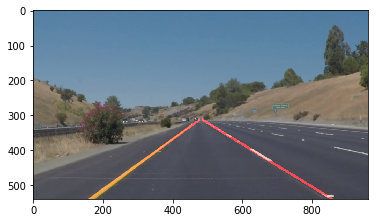

In [61]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [62]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [03:46<00:00,  1.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 3min 36s, sys: 5.82 s, total: 3min 42s
Wall time: 3min 48s


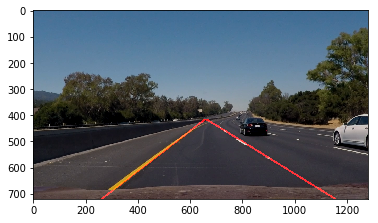

In [140]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))